# **Аналитика ДТП**
Заказчиком выступает проект [«Карта ДТП»](https://dtp-stat.ru/) — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России.

## Часть 1. Подготовка данных и предобработка



<a id="#start"></a>
## 1 Постановка задачи и ход исследования

**Цель:**  

Провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Описание задачи**:
- Провести исследовательский анализ данных о дорожно-транспортных происшествиях (ДТП).
- Сформулировать и проверить гипотезы, основываясь на имеющихся признаках.
- Построить дашборд используя любой удобный инструмент, с учетом того, что дашборд может быть опубликован

**В исследовании произведем:**
- загрузку данных с сайта в рабочую папку
- обработку данных, в том числе списков и .json
- формирование сводных датафреймов, выделение датафреймов с данными об автомобилях и людях - участниках ДТП
- сохранение и выгрузку на диск обработанных данных в формате `.pickle`
- исследовательский анализ данных
- формирование и проверку гипотез:
  - В большинстве случаев виноваты пьяные водители, нужно усилить контроль
  - Безопасность на дорогах растет для каждого из участников
  - В личном автомобиле ехать безопаснее чем в автобусе
  - Если пешеходы не будут нарушать, то не будут гибнуть
  - Низкая скорость не влияет на тяжесть ДТП
  - В зависимости от местонахождения - `nearby`
  - В зависимости от состояния дороги `road_conditions`
  - В зависимости от географической широты места ДТП
  - В зависимости от гцвета ТС
  - В зависимости от включенных или не включенных ходовых огней
- построение дашборда средствами DataLens

**Ход исследования:**
- Часть 1:
  - Загрузка данных из предоставленных файлов и подготовка их к анализу
  - Обработка данных, Изучение общей информации о датафрейме
  - Расчет и определение дополнительных данных
  - Объединение данных в сводные таблицы
- Часть 2:
  - Исследовательский анализ данных
  - Проверка гипотех
  - Построение дашборда
  - Выводы и заключения

<a id="library"></a>
## 2 Импорт библиотек и создание функций


### 2.1. Установка дистрибутивов

In [ ]:
#pip install pandas-geojson --quiet

In [ ]:
pip install dill --quiet

### 2.2. Установка библиотек




In [ ]:
# для извлечения и анализа данных
import pandas as pd
import os
#from pandas_geojson import read_geojson
import re
import requests
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import warnings
import time # для расчета времени обработки ноутбука
import logging
import dill as pickle # для сериализации объектов и сохранения данных в формате .pickle
import json
import matplotlib.pyplot as plt

# настройка отображения
pd.options.display.max_columns = 30

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.3. Создание функций




In [ ]:
# Создадим функцию для загрузки файлов json
def read_geojson(filename):
    with open(f'{filename}', encoding= 'utf-8') as response:
        geo_json = json.load(response)
    return geo_json

In [ ]:
# Создадим функцию для исследования данных

def first_look_data(data):
    print('\033[92m''\033[1m''\033[4m''Общий вид датафрейма''\033[0m')
    display(data.sample(3).T)
    print('\033[92m''\033[1m''\033[4m''Названия столбцов''\033[0m')
    print(data.columns)

    print(50*'-')
    print('\033[92m''\033[1m''\033[4m''Содержимое столбцов''\033[0m')
    print(20*'*')

    for col in data:
        print("\033[1m""\033[94m", col, "\033[0m")
# Не во всех столбцах могут быть определены unique и nunique
        try:
            print("\033[1m""\033[94m""Уникальные значения""\033[0m", data[col].unique())
            print("\033[1m""\033[94m""Количество уникальных значений""\033[0m", data[col].nunique())

# Если не могут быть определены, то:
        except TypeError:
            print("\033[1m""\033[91m"'Списковое исключение или json'"\033[0m")

            print(data[col][:5])

        print(20*'*')
    print('\033[92m''\033[1m''\033[4m''Общая информация''\033[0m')
    print(data.info())

    print(50*"-")
    print('\033[92m''\033[1m''\033[4m''Доля незаполненных значений в столбцах, %''\033[0m')
    for i in data:
        if data[i].isna().mean()>0:
            print(i, round(data[i].isna().mean()*100, 2))
    #df = df.drop([col for col in df.columns if 'type' in col], axis =1)
    print(50*"-")

In [ ]:
# Чтобы выделить в отдельный датафрейм json структуры (столбцы)
# Применим метод json_normalize.
# Создадим функцию normalize_json_to_data

def normalize_json_to_data(data, col):

    data_out = pd.json_normalize(data.explode(col)[col])

# Для возможности дальнейшего анализа "привяжем" в создаваемые таблицы id события (ДТП)
    data_out = pd.concat([
        pd.DataFrame(data.explode(col)['id'].values, columns=['id']),
        data_out
    ],
        axis=1)
    return data_out

In [ ]:
# Функция change_type для изменения типа данных в столбцах
def change_type(df_name, column, new_type):

    # для дальнейшей проверки сохраним значения столбца до изменения типа данных
    col_before = pd.DataFrame()
    for i in column:
        col_before[i] = df_name[i].tolist()

    #print("Initially Memory usage:")
    #print(df_name[column].memory_usage())
    #print()
    df_name[column]=df_name[column].astype(new_type)
    #print("Memory used after optimization:")
    #print(df_name[column].memory_usage())

    # Сравним столбцы до и после изменения типа данных
    #if (col_before == df_name[column].tolist()):
     #   print("\033[1m""\033[94m"'cовпадают'"\033[0m")
    #else:
     #   print("\033[1m""\033[91m"'не совпадают!'"\033[0m")

    # Сравним столбцы до и после изменения типа данных
    for i in column:
        if (col_before[i].tolist() == df_name[i].tolist()):
           #print("\033[94m""Для столбца ", i,"\033[1m" 'Значения cовпадают'"\033[0m")
           pass
        else:
           print("\033[91m""Для столбца ", i,"\033[1m" 'Значения не cовпадают!'"\033[0m")

    return

In [ ]:
# Функция lower_and_strip для удаления лишних пробелов и понижения регистра,
# для заполнения пропущенных значений и присвоения данным типа category
def lower_and_strip(df, list_name):
  for i in list_name:
    #print(i, df[i].dtype)
    df[i] = df[i].str.strip()
    df[i] = df[i].fillna('Не заполнено')
    #print(df[i].unique().tolist())
  change_type(df, list_name, 'category')
  #print('\033[91m''Total memory_usage, MB ', (df.memory_usage().sum()/(10**6)).round(2))

In [ ]:
# Посчитаем максимальное количество элементов в списковых исключениях
# и посмотрим их максимальное значение.

def count_max_elemets_from_list_except(data):
    # зададим переменную для учета наименований столбцов, в которых присутствуют списки
    roll_of_lists = []
    for col in data:
        try:
            data[col].unique()
            print('Column name ', col, 'is not list')


        except TypeError:
            print("\033[1m""\033[91m"'Списковое исключение или json'"\033[0m")
            print('\033[94m'f'Столбец {col}''\033[0m')
            print('Списковое исключение. max количество значений в одном списке - ', data[col].apply(lambda x: len(x)).max())
            try:
                #print(data[col].apply(lambda x: len(x)).max())
                print('Количество уникальных значений -',data.explode(col)[col].nunique())

                #  explode разделяет list
                print(f'Перечень уникальных значений {df.explode(col)[col].unique()}')

                # запишем название столбца, в котором присутствуют списки, в переменную roll_of_lists
                roll_of_lists.append(col)
            except TypeError:
                print('\033[91m''JSON''\033[0m')
            print(40*'-')
    return(roll_of_lists)

In [ ]:
''' Создадим функцию `converting_columns_with_lists`,
которая:
- принимает на входе имя датафрейма и имя трансформируемого столбца
- создаст список из уникальных элементов, входящих в списки столбцов, содержащих списки (это столбцы 'coordinates',  'tags',  'nearby', 'weather',  'road_conditions', 'participant_categories'). Список этих столбцов (в которых присутствуют списки) мы поместили в переменую `roll_of_lists`
- переведет список в датафрейм, где каждой записи (каждому событию ДТП) будет соответствовать "переключатель" 0 или 1 в зависимости от наличия одного или нескольких уникальных элементов, входящих в списки столбца
- построит график частоты появления комбинаций уникальных событий
- для удобства чтения графика визуализирует порядок следования и расположения уникальных элементов списка в строке
- создаст  и сохранит на диск датафрейм событий по типу one hot encoding.
'''
def converting_columns_with_lists(df, col_name):
  print('\033[95m''\033[1m'f'Обработаем столбец {col_name}''\033[0m')
  # Создадим список, который будет ключом к индексам, полученным из данных трансформируемого столбца
  weather_list = list(df.explode(col_name)[col_name].unique())
  #print(weather_list)

  # Создадим функцию по переводу списка в датафрейм, где каждой записи (каждому событию ДТП) будет соответствовать
  # "переключатель" 0 или 1 в зависимости от наличия одного или нескольких уникальных элементов, входящих в списки столбца
  def return_w(row, param, col_list):
    # Индекс в строке будет соответсвовать номеру в списке.
    # 0 - нет признака, 1 есть признак.
    # Создадим список из 0 в строчном формате.
    number_list = ['0' for i in range(len(col_list))]

    # Если значение в строке больше нуля то заменяем 0 значением 1 по индексу
    if len(row[param]) >0:
        index_list = [col_list.index(i) for i in row[param]]
        for ind in index_list:
            number_list[ind] = '1'

    # Возвращаем данные в виде строки, разделенной запятыми.
    return ','.join(number_list)

  # Посчитаем полученные значения.
  weather_df_count = df.apply(return_w, axis=1, args=(col_name, weather_list,)).value_counts()
  weather_df_count_head_20 = weather_df_count.head(20).copy()
  print('\033[94m''ТОП-20 полученных значений''\033[0m')
  display(weather_df_count_head_20)

  # Построим график.

  plt.figure(figsize=(12,6))
  weather_df_count_head_20.plot(kind='bar', grid=False, color = 'blue')
  plt.title(f'График {col_name}', color = 'b')
  plt.xlabel(f'Вариант {col_name}')
  plt.ylabel('Число случаев')
  plt.show()

  # Визуализируем порядок следования и расположения уникальных элементов (индексов) в строке
  weather_list_df = pd.DataFrame({'serial_number': list(range(1,len(weather_list)+1)),
                                col_name: weather_list})\
                                .set_index('serial_number')
  print('\033[94m''Порядок следования и расположения уникальных элементов (индексов) в строке''\033[0m')
  display(weather_list_df)

  if col_name == 'violations':
    return

  # Подготовим датафрейм содержащий id событий. Он понадобится нам для формирования датафрейма событий по типу one hot encoding.
  weather_ohe = pd.DataFrame()
  weather_ohe['id'] = df['id'].copy()

  # Создадим датафрейма событий по типу one hot encoding.
  weather_ohe[weather_list] = df.apply(return_w, axis=1, args=(col_name, weather_list,)
                                     ).str.split(',', expand=True).astype(int)

  pd.set_option('display.max_colwidth', None)
  print('\033[94m''Датафрейм событий по типу one hot encoding''\033[0m')
  display(weather_ohe.head())
  #pd.reset_option('display.max_colwidth')
  print('\033[94m''Информация о датафрейме событий по типу one hot encoding''\033[0m')
  display(weather_ohe.info())

  # Изменим тип данных для столбцов и установим его int8
  change_type(weather_ohe, weather_ohe.columns[1:], 'int8')

    # Посмотрим описательные статистики.

  display(weather_ohe.describe().T)

  # Сохраним созданный датафрейм на диск в формате `.pickle`
  # в переменную dim созраним окончание и расширение создаваемого файла
  dim = '_ohe.pickle'
  #for i in range(len(df.columns)):
  # создадим имя сохраняемого файла
  pickle_file_name = col_name+dim
  # Сохраним созданный датафрейм на диск
  with open(pickle_file_name, "wb") as file:
      pickle.dump(weather_ohe, file)
  #print(df.columns[i]+dim)

  return(weather_ohe)

In [ ]:
# Создадим функцию, которая вернет нам обработанные датафреймы


def return_true_dfs(path, number_data):
    # Загрузим в переменную geo_json файл из списка
    geo_json = read_geojson(os.path.join('dtp', path))  # Получаем файл geo_json

    # Нормализуем файл json и получим датафрейм
    df = pd.json_normalize(geo_json['features'])

    # Удалим столбцы type и geometry.type
    df = df.drop(columns=['type', 'geometry.type'])
    # Изменим наименования столбцов, удалим первые части в названиях
    df.columns = [col.split('.')[-1] for col in df.columns]
    # Удалим столбец scheme
    df = df.drop(columns=['scheme'])

    # Преобразуем тип столбца 'dead_count', 'injured_count', 'participants_count' в int8
    change_type(df, list_int64[1:], 'int8')
    # Преобразуем тип столбца id в int32
    change_type(df, ['id'], 'int32')
    # Сразу снижаем размерность id
    #df['id'] = df['id'].astype('int32')
    # удалим возможные пробелы в начале и конце записей в столбцах с типом category
    for i in ["light", "category","severity","parent_region"]:
        df[i] = df[i].str.strip()

    # Преобразуем тип столбца `light`, `category `, `severity`, `parent_region` в category
    change_type(df, ["light", "category","severity","parent_region"], 'category')


    # Прописываем условие, определяющее, для какого датасета произвести расчет.

    if number_data == 1:
        # Общий датафрейм (без json столбцов)
        # Приведем столбец даты datetime в формат даты-времени
        df['datetime'] = pd.to_datetime(df['datetime'])
        # Удалим столбцы 'participants', 'vehicles'
        return df.drop(['participants', 'vehicles'], axis=1)

    if number_data == 2:
        # Датафрейм для машин.
        # Нормализуем  столбкц vehicles
        df_vehicles = normalize_json_to_data(df,
                                             'vehicles').reset_index(drop=True)
        # Приведем столбец id в формат int32
        change_type(df_vehicles, ['id'], 'int32')

        # Приведем данные в столбце year к числовому формату
        df_vehicles.year = pd.to_numeric(df_vehicles.year)
        # Заменим пропущенные значения и значения "1900" и "1" на "Не указано"
        df_vehicles.year = df_vehicles.year.fillna('Не заполнено')
        df_vehicles.year = df_vehicles.year.replace({1:'Не заполнено',1900:'Не заполнено'})
        # Приведем данные в столбце year к целочисленному формату
        df_vehicles.loc[(df_vehicles['year'] != "Не заполнено"), 'year'] = \
        df_vehicles.loc[(df_vehicles['year'] != "Не заполнено"), 'year'].astype(int)

        # удалим лишние пробелы и понизим регистр и изменим тип записей на категориальные значения
        # для столбцов из списка list_category_vehicles = ['brand', 'color', 'model', 'category']
        lower_and_strip(df_vehicles, list_category_vehicles)

        # Удалим столбец 'participants',
        return df_vehicles.drop(['participants'], axis=1)

    if number_data == 3:
        # Датафрейм для автомобилей только с id  и участниками.
        df_vehicles = normalize_json_to_data(
            df, 'vehicles').reset_index(drop=True)[['id', 'participants']]
        # Датафрейм для водителей,пассажиров машин.
        df_vehicles_participants = normalize_json_to_data(
            df_vehicles, 'participants').reset_index(drop=True)

        # Датафрейм для пешеходов.

        # Дополнительно удалим все пустые строки, так как там нет пешеходов.
        df_footer = normalize_json_to_data(
            df, 'participants').dropna().reset_index(drop=True)

        # Пропущенные значения в столбцах role, gender, health_status - заменим на значение "Не определено"
        # Приведем столбцы role, gender, health_status в формат category
        #lower_and_strip(df_vehicles_participants, ['role', 'gender', 'health_status'])
        #lower_and_strip(df_footer, ['role', 'gender', 'health_status'])

        #  Объединим таблицы df_footer и df_vehicles_participants
        return pd.concat(
            [df_vehicles_participants,
             df_footer]).copy().reset_index(drop=True)
             #.dropna(#subset='role')

    # Возвращаем пустое значение, если ни одно условие не выполнилось.

    return

<a id="#loading"></a>
## 3 Загрузка данных с [сайта](https://dtp-stat.ru/)  на диск

In [ ]:
# Загрузим страницу по ссылке и запишем данные.
base_url = 'https://dtp-stat.ru/opendata'

hd = {
        'User-Agent': 'Mozilla/5.0 (compatible; U; ABrowse 0.6; Syllable) AppleWebKit/420+ (KHTML, like Gecko)'
      }

response = requests.get(base_url,headers=hd)

# Можно записать данные.
with open('dtp.html', 'wb') as file:
    file.write(response.content)

Используем регулярное выражение для получения данных и получения списка загружаемых файлов.

In [ ]:
# Получаем список ссылок, для загрузки файлов.
list_for_download = re.findall(r'https:\/\/cms.dtp-stat.ru[\S][^\"\n]+',response.text)

Создадим функцию `write_url_to_file` для загрузки файлов с сайта

In [ ]:
# Функция для загрузки файлов с сайта.
def write_url_to_file(url):
    response = requests.get(url)

#   Добавление пути файла и замена в имени файла дефиса ни нижнее подчеркивание.
    path = f'dtp/' + re.search(r"[\w-]+.geojson", url)[0].replace('-', '_')

#   Запись в файл.
    file = open(path, "wb")
    file.write(response.content)
    file.close()
    return

Перейдем в рабочую папку


In [ ]:
os.chdir('/content/drive/MyDrive/Мастерская_Аналитика_ДТП')

In [ ]:
#os.listdir()

In [ ]:
# Создадим папку для сохранения файлов с сайта
if os.path.isdir('dtp') == False:
    os.mkdir('dtp')

In [ ]:
# Запустим функцию.
for url in tqdm(list_for_download):
    write_url_to_file(url)


100%|██████████| 85/85 [02:31<00:00,  1.78s/it]


Данные загружены с сайта на диск.

## 4 Загрузка и исследование одного из файлов

### Установка библиотек




In [ ]:
pip install dill --quiet

In [ ]:
# для извлечения и анализа данных
import pandas as pd
import os
#from pandas_geojson import read_geojson
import re
import requests
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import warnings
import time # для расчета времени обработки ноутбука
import logging
import dill as pickle # для сериализации объектов и сохранения данных в формате .pickle
import json
import matplotlib.pyplot as plt

# настройка отображения
pd.options.display.max_columns = 30

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Перейдем в рабочую папку
os.chdir('/content/drive/MyDrive/Мастерская_Аналитика_ДТП')

Зададим код для отмены визуализации полного содержимого столбцов

In [ ]:
pd.reset_option('display.max_colwidth')

In [ ]:
# Прочитаем файлы в дирректории dtp и переведем первый файл в датафрейм
list_file = os.listdir('dtp')

In [ ]:
# Посчитаем общее число скачанных файлов.
print(f'Общее число файлов в директории dtp {len(list_file)}.')

Общее число файлов в директории dtp 85.


Создадим функцию `read_geojson` для загрузки файлов json.  
Загрузим в переменную `geo_json` первый файл из списка и ознакомимся с ним.  

Используем функцию для загрузки файлов json `read_geojson`

In [ ]:
geo_json = read_geojson(os.path.join('dtp',list_file[0]))

In [ ]:
# Попробуем прочитать файл
pd.json_normalize(geo_json)

,type,features
0,FeatureCollection,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."


In [ ]:
geo_json.keys()

dict_keys(['type', 'features'])

In [ ]:
# содержимое первого ключа
geo_json['type']

'FeatureCollection'

In [ ]:
# Первый элемент второго ключа

geo_json['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [129.848292, 49.796572]},
 'properties': {'id': 2525237,
  'tags': ['Дорожно-транспортные происшествия'],
  'light': 'В темное время суток, освещение отсутствует',
  'point': {'lat': 49.796572, 'long': 129.848292},
  'nearby': [],
  'region': 'Бурейский район',
  'scheme': '840',
  'address': 'Прогресс – Бурея – Новобурейск, 24 км',
  'weather': ['Пасмурно'],
  'category': 'Наезд на пешехода',
  'datetime': '2020-12-10 17:40:00',
  'severity': 'Легкий',
  'vehicles': [{'year': 2018,
    'brand': 'ПАЗ',
    'color': 'Белый',
    'model': '32054',
    'category': 'Прочие одноярусные',
    'participants': [{'role': 'Водитель',
      'gender': 'Мужской',
      'violations': [],
      'health_status': 'Не пострадал',
      'years_of_driving_experience': 35}]}],
  'dead_count': 0,
  'participants': [{'role': 'Пешеход',
    'gender': 'Мужской',
    'violations': ['Движение вдоль проезжей части попутного направления вне населенн

Файл содержит два столбца.  
В первомсодержится единственное значение FeatureCollection - оно не интерсно нам.  
Во втором - информация в формате json.  
### 4.1. Развернем информацию из формата json

In [ ]:
# Попробуем преобразовать в DataFrame

pd.DataFrame(geo_json).head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."


In [ ]:
# Используем нормализацию json из бибилотеки pandas - json_normalize

df = pd.json_normalize(geo_json['features'])

# Прочитаем первые пять строк и транспонируем таблицу для удобства.

df.head().T

,0,1,2,3,4
type,Feature,Feature,Feature,Feature,Feature
geometry.type,Point,Point,Point,Point,Point
geometry.coordinates,"[129.848292, 49.796572]","[129.769821, 49.83001]","[129.90612, 49.798774]","[129.982574, 49.821165]","[130.14165, 50.193372]"
properties.id,2525237,2060303,2624862,2624870,2536793
properties.tags,[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия]
properties.light,"В темное время суток, освещение отсутствует","В темное время суток, освещение отсутствует",Светлое время суток,Светлое время суток,"В темное время суток, освещение отсутствует"
properties.point.lat,49.796572,49.83001,49.798774,49.821165,50.193372
properties.point.long,129.848292,129.769821,129.90612,129.982574,130.14165
properties.nearby,[],[],[АЗС],[],[]
properties.region,Бурейский район,Бурейский район,Бурейский район,Бурейский район,Бурейский район


In [ ]:
# Смотрим общую информацию.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   type                               11064 non-null  object 
 1   geometry.type                      11064 non-null  object 
 2   geometry.coordinates               11064 non-null  object 
 3   properties.id                      11064 non-null  int64  
 4   properties.tags                    11064 non-null  object 
 5   properties.light                   11064 non-null  object 
 6   properties.point.lat               10860 non-null  float64
 7   properties.point.long              10860 non-null  float64
 8   properties.nearby                  11064 non-null  object 
 9   properties.region                  11064 non-null  object 
 10  properties.scheme                  10191 non-null  object 
 11  properties.address                 10478 non-null  obj

Проверим уникальность данных в столбцах `type` и `geometry.type`

Убедимся, что значиения в них - единственные


In [ ]:
df['geometry.type'].unique()

array(['Point'], dtype=object)

In [ ]:
df.type.unique()

array(['Feature'], dtype=object)

Удалим столбцы `type` и `geometry.type`

In [ ]:
df = df.drop(columns=['type', 'geometry.type'])

Изменим наименования столбцов, удалим первые части в названиях


In [ ]:
#df = df.drop([col for col in df.columns if 'type' in col], axis =1)
df.columns = [col.split('.')[-1] for col in df.columns]
df.columns

Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'road_conditions', 'participants_count',
       'participant_categories'],
      dtype='object')

Раскроем и расшифруем данные в датафрейме

    "id"  # идентификатор
    "tags"  # показатели с официального сайта ГИБДД
    "light"  # время суток
    "point"  # координаты
    "nearby"  # объекты рядом
    "region" # город/район
    "address" # адрес
    "weather"  # погода
    "category"  # тип ДТП
    "datetime"  # дата и время
    "severity" # тяжесть ДТП/вред здоровью
    "vehicles": [  # участники – транспортные средства
        {
            "year":
            2010,  # год производства транспортного средства
            "brand":
            "ВАЗ",  # марка транспортного средства
            "color":
            "Иные цвета",  # цвет транспортного средства
            "model":
            "Priora",  # модель транспортного средства
            "category":
            "С-класс (малый средний, компактный) до 4,3 м",  # категория транспортного средства
            "participants": [  # участники внутри транспортных средств
                {
                    "role": "Водитель",  # роль участника
                    "gender": "Женский",  # пол участника
                    "violations": [],  # нарушения правил участником
                    "health_status":
                    "Раненый, находящийся...",  # состояние здоровья участника
                    "years_of_driving_experience" # стаж вождения участника (только у водителей)
                }
            ]
        },
    ],
    "dead_count" # кол-во погибших в ДТП
    "participants" # участники без транспортных средств (описание, как у участников внутри транспортных средств)
    "injured_count" # кол-во раненых в ДТП
    "parent_region" # родительский регион (основной)
    "road_conditions" # состояние дорожного покрытия
    "participants_count" # кол-во участников ДТП
    "participant_categories" # категории участников


Часть данных находится в форматах json или list.  
### 4.2. Выделим данные в форматах json или list в отдельный датафрейм для json и переведем в более удобный формат для list.

Вызовем функцию для исследования данных `first_look_data`

In [ ]:
first_look_data(df)

Общий вид датафрейма


,7533,9735,7140
coordinates,"[127.497604, 50.284897]","[127.8686, 50.4856]","[127.413104, 50.291752]"
id,2945915,2063964,2591892
tags,[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия]
light,"В темное время суток, освещение включено","В темное время суток, освещение включено","В темное время суток, освещение включено"
lat,50.284897,50.4856,50.291752
long,127.497604,127.8686,127.413104
nearby,"[Производственное предприятие, Административны...","[Многоквартирные жилые дома, Крупный торговый ...",[Жилые дома индивидуальной застройки]
region,Благовещенск,Благовещенск,Благовещенск
scheme,940,070,940
address,"г Благовещенск, ул Студенческая, 6 3А","г Благовещенск, ш Новотроицкое, 3",None


Названия столбцов
Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'road_conditions', 'participants_count',
       'participant_categories'],
      dtype='object')
--------------------------------------------------
Содержимое столбцов
********************
 coordinates 
Списковое исключение или json
0    [129.848292, 49.796572]
1     [129.769821, 49.83001]
2     [129.90612, 49.798774]
3    [129.982574, 49.821165]
4     [130.14165, 50.193372]
Name: coordinates, dtype: object
********************
 id 
Уникальные значения [2525237 2060303 2624862 ... 2060135 2060142 2063100]
Количество уникальных значений 11064
********************
 tags 
Списковое исключение или json
0    [Дорожно-транспортные происшествия]
1    [Дорожно-транспортные происшествия]
2    [Дорожно-транспортные происшествия]
3    [До

Рассмотрев информацию, мы можем указать следующее:
- Есть списки
- Есть json
- Есть столбец `scheme`, которого нет в описании
- Столбец даты не приведен к нужному формату
- Целочисленные данные представлены в в формате `int64`
- Данные в следующих столбцах могут быть рассмотрены как категориальные величины: `light`, `category`, `severity`, `parent_region`
- Явных и неявных дубликатов не наблюдается. В столбце region есть в ряде случаев пересечения вида: 'Рубцовск', 'Рубцовский район'.


Предпримем:
- Разделим списки
- Разделием json
- По пояснению Заказчика в столбце `scheme` указан код для соответствующей схему ДТП. Для нашего исследования схема ДТП не несет информации. Удалим столбец `scheme`
- Приведем столбец даты `datetime` в формат даты-времени
- Приведем столбцы `id`, `injured_count`, `participants_count` в формат `int32` или `int16` и проверим на отсутствие потерянных значений
- Приведем столбцы `light`, `category`, `severity`,  `parent_region` в формат `category` и проверим на отсутствие потерянных значений
- Оставим на этом этапе содержимое столбца region без изменений

Выделим в отдельный датафрейм json структуры (столбцы).

Применим метод json_normalize.

Вызовем функцию `normalize_json_to_data`

#### Создадим датафреймы
- Для транспорта, участвовавшего в ДТП,  
- Для водителей и пассажиров транспора, участвовавшего в ДТП  
- Для пешеходов, участвовавших в ДТП

In [ ]:
# Датафрейм для машин.

df_vehicles = normalize_json_to_data(df, 'vehicles').reset_index(drop=True)

# Датафрейм для пассажиров машин.

df_vehicles_participants = normalize_json_to_data(
    df_vehicles, 'participants').reset_index(drop=True)

# Датафрейм для пешеходов.
# Дополнительно удалим все пустые строки, так как там нет пешеходов.
df_footer = normalize_json_to_data(
    df, 'participants').dropna().reset_index(drop=True)

Ознакомимся с содержимым датафрейма с транспортом, участвовавшем в ДТП

In [ ]:
first_look_data(df_vehicles)

Общий вид датафрейма


,8138,708,12473
id,2064508,2823554,2058394
year,1999.0,2012.0,2010.0
brand,TOYOTA,SSANGYONG,NISSAN
color,Белый,Коричневый,Белый
model,Cresta,Actyon,Tiida
category,"В-класс (малый) до 3,9 м","В-класс (малый) до 3,9 м","В-класс (малый) до 3,9 м"
participants,"[{'role': 'Водитель', 'gender': 'Женский', 'vi...","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...","[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."


Названия столбцов
Index(['id', 'year', 'brand', 'color', 'model', 'category', 'participants'], dtype='object')
--------------------------------------------------
Содержимое столбцов
********************
 id 
Уникальные значения [2525237 2060303 2624862 ... 2060135 2060142 2063100]
Количество уникальных значений 11064
********************
 year 
Уникальные значения [2.018e+03 2.003e+03 2.014e+03 2.011e+03 2.010e+03 2.013e+03 1.980e+03
 1.993e+03 1.988e+03 2.017e+03 1.999e+03 2.005e+03 1.985e+03 1.982e+03
 1.987e+03 2.000e+03 2.012e+03 1.996e+03 1.998e+03 1.997e+03 1.990e+03
       nan 2.020e+03 1.986e+03 1.984e+03 2.016e+03 2.021e+03 2.007e+03
 2.002e+03 1.983e+03 2.001e+03 2.008e+03 2.004e+03 2.006e+03 2.019e+03
 1.975e+03 1.994e+03 2.009e+03 1.992e+03 1.991e+03 2.022e+03 1.989e+03
 1.974e+03 2.015e+03 1.995e+03 1.977e+03 2.023e+03 1.981e+03 1.979e+03
 1.978e+03 1.972e+03 1.969e+03 1.967e+03 1.000e+00 1.968e+03 1.959e+03
 1.976e+03 1.963e+03 1.970e+03 1.973e+03 1.962e+03 1.900e+03]
Кол

Рассмотрев информацию, мы можем указать следующее:
- Есть json - столбец `participants`
- Столбец `year` (год выпуска транспортного средства) приведен в формате `float64`. В столбце присутствуют некорректные значения - "1900" и "1"
- Целочисленные данные - столбец `id` - представлены в в формате `int64`
- Данные в следующих столбцах могут быть рассмотрены как категориальные величины: `brand`, `color`, `model`, `category`
- Отсутствует ряд значений в столбцах year, brand, color, model, category,
participants

Предпримем:
- Разделием json
- Приведем столбцы `id`, `year` в формат `int32` или `int16` и проверим на отсутствие потерянных значений
- Значения "1900" и "1" заменим на медианные значения
- Приведем столбцы `brand`, `color`, `model`, `category` в формат `category` и проверим на отсутствие потерянных значений
- Пропущенные значения в столбцах:
 - year - заменим на медианные значения
 - brand, color, model, category - заменим на значение "Не определено"


Ознакомимся с содержимым датафрейма с данными о водителях и пассажирах транспора, участвовавшего в ДТП


In [ ]:
first_look_data(df_vehicles_participants)

Общий вид датафрейма


,12481,12436,15694
id,2059777,2064085,2603166
role,Пассажир,Пассажир,Пассажир
gender,Мужской,Женский,Женский
violations,[Нарушение правил применения ремней безопаснос...,[],[]
health_status,"Раненый, находящийся (находившийся) на стацион...","Раненый, находящийся (находившийся) на стацион...","Раненый, находящийся (находившийся) на амбулат..."
years_of_driving_experience,NaN,NaN,NaN


Названия столбцов
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое столбцов
********************
 id 
Уникальные значения [2525237 2060303 2624862 ... 2060135 2060142 2063100]
Количество уникальных значений 11064
********************
 role 
Уникальные значения ['Водитель' 'Пассажир' 'Велосипедист' nan
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира'
 'Пешеход']
Количество уникальных значений 5
********************
 gender 
Уникальные значения ['Мужской' 'Женский' None nan]
Количество уникальных значений 2
********************
 violations 
Списковое исключение или json
0                                                   []
1                                                   []
2                                                   []
3                                        

Рассмотрев информацию, мы можем указать следующее:
- Есть списки - столбец `violations`
- Столбец `years_of_driving_experience` (стаж вождения) приведен в формате `float64`
- Целочисленные данные - столбец `id` - представлены в в формате `int64`
- Данные в следующих столбцах могут быть рассмотрены как категориальные величины: `role`, `gender`, `health_status`
- Отсутствует ряд значений во всех столбцах

Предпримем:
- Разделием списки
- Приведем столбцы `id`, `years_of_driving_experience` в формат `int32` или `int16` и проверим на отсутствие потерянных значений
- Приведем столбцы `role`, `gender`, `health_status` в формат `category` и проверим на отсутствие потерянных значений
- Пропущенные значения в столбцах:
 - `years_of_driving_experience` - оставим без изменений
 - `role`, `gender`, `health_status` - заменим на значение "Не определено"

Ознакомимся с содержимым датафрейма с данными о пешеходах, участвовавших в ДТП

In [ ]:
first_look_data(df_footer)

Общий вид датафрейма


,1987,766,2622
id,2064076,2064018,2057888
role,Пешеход,Пешеход,Пешеход
gender,Женский,Мужской,Мужской
violations,[],"[Иные нарушения, Пешеход в состоянии алкогольн...",[Переход через проезжую часть в неустановленно...
health_status,"Раненый, находящийся (находившийся) на амбула...","Раненый, находящийся (находившийся) на стацион...","Раненый, находящийся (находившийся) на амбула..."


Названия столбцов
Index(['id', 'role', 'gender', 'violations', 'health_status'], dtype='object')
--------------------------------------------------
Содержимое столбцов
********************
 id 
Уникальные значения [2525237 2780297 2876916 ... 2061846 2059993 2060135]
Количество уникальных значений 2675
********************
 role 
Уникальные значения ['Пешеход'
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира']
Количество уникальных значений 2
********************
 gender 
Уникальные значения ['Мужской' 'Женский']
Количество уникальных значений 2
********************
 violations 
Списковое исключение или json
0    [Движение вдоль проезжей части попутного напра...
1    [Переход через проезжую часть вне пешеходного ...
2                                                   []
3    [Нахождение на проезжей части без цели её пере...
4    [Переход через проезжую часть в неустановленно...
Name: violations, dtype: ob

Рассмотрев информацию, мы можем указать следующее:
- Есть списки - столбец `violations`
- Целочисленные данные - столбец `id` - представлены в в формате `int64`
- Данные в следующих столбцах могут быть рассмотрены как категориальные величины: `role`, `gender`, `health_status`
- Отсутствующих значений не выявлено

Предпримем:
- Разделием списки
- Приведем столбец `id` в формат `int32` или `int16` и проверим на отсутствие потерянных значений
- Приведем столбцы `role`, `gender`, `health_status` в формат `category` и проверим на отсутствие потерянных значений

### 4.3. Обработаем полученные датафреймы в соответствии с намеченными выше действиями

#### Датафрейм df

In [ ]:
# Приведем столбец даты datetime в формат даты-времени
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
# Удалим столбец scheme
df = df.drop(columns=['scheme'])

Приведем столбцы id, injured_count, participants_count в формат int32 или int16 и проверим на отсутствие потерянных значений

In [ ]:
df.dtypes [df.dtypes == 'int64']

id                    int64
dead_count            int64
injured_count         int64
participants_count    int64
dtype: object

In [ ]:
# Сформируем список столбцов с целочисленными значениями
list_int64 = []
for i in df.columns:
  if df[i].dtype == 'int64':
    #print(i, df[i].dtype)
    list_int64.append(i)

In [ ]:
list_int64

['id', 'dead_count', 'injured_count', 'participants_count']

In [ ]:
# Ознакомимся с диапазоном значений столбцов с целочисленными данными
for i in list_int64:
  print('for ', i, ': max_val = ', df[i].max(), ', min_val = ', df[i].min())

for  id : max_val =  2945928 , min_val =  2057598
for  dead_count : max_val =  6 , min_val =  0
for  injured_count : max_val =  18 , min_val =  0
for  participants_count : max_val =  25 , min_val =  1


In [ ]:
# для дальнейшей проверки сохраним в список значения столбца до изменения типа данных
#col_before = df.id.tolist()

Вызовем функцию `change_type` для изменения типа данных в столбцах

In [ ]:
# Преобразуем тип столбца 'dead_count', 'injured_count', 'participants_count' в int8
change_type(df, list_int64[1:], 'int8')

In [ ]:
# Преобразуем тип столбца id в int32
change_type(df, ['id'], 'int32')

Приведем столбцы `light`, `category`, `severity`,  `parent_region` в формат category и проверим на отсутствие потерянных значений

Подстрахуемся и удалим возможные пробелы в начале и конце записей в столбцах с типом `category`

In [ ]:
for i in ["light", "category","severity","parent_region"]:
    print(i, df[i].dtype)
    df[i] = df[i].str.strip()

light object
category object
severity object
parent_region object


Столбцы, которые можно определить как категориальные данные
- "category": "Столкновение", # тип ДТП
- "severity": "Легкий", # тяжесть ДТП/вред здоровью
- "participants": [], # участники без транспортных средств (описание, как у участников внутри транспортных средств)
- "road_conditions": ["Сухое"], # состояние дорожного покрытия
- "participant_categories": ["Все участники", "Дети"] # категории участников


In [ ]:
list_category = ["light","weather", "category","severity","participants","road_conditions","participant_categories"]

In [ ]:
list_category = ["light", "category","severity","parent_region"]

In [ ]:
for i in list_category:
  print('category = ', i, ', values = ', df[i].tolist()[:10])

category =  light , values =  ['В темное время суток, освещение отсутствует', 'В темное время суток, освещение отсутствует', 'Светлое время суток', 'Светлое время суток', 'В темное время суток, освещение отсутствует', 'Светлое время суток', 'В темное время суток, освещение отсутствует', 'В темное время суток, освещение отсутствует', 'Светлое время суток', 'В темное время суток, освещение отсутствует']
category =  category , values =  ['Наезд на пешехода', 'Наезд на препятствие', 'Столкновение', 'Съезд с дороги', 'Опрокидывание', 'Съезд с дороги', 'Столкновение', 'Столкновение', 'Наезд на пешехода', 'Съезд с дороги']
category =  severity , values =  ['Легкий', 'С погибшими', 'Легкий', 'Легкий', 'Легкий', 'С погибшими', 'Легкий', 'С погибшими', 'Легкий', 'С погибшими']
category =  parent_region , values =  ['Амурская область', 'Амурская область', 'Амурская область', 'Амурская область', 'Амурская область', 'Амурская область', 'Амурская область', 'Амурская область', 'Амурская область', 'Ам

Тип данных в столбцах `light`, `category `, `severity`, `parent_region` могут быть приведены к категориальному типу данных.   


In [ ]:
# Преобразуем тип столбца `light`, `category `, `severity`, `parent_region` в category
change_type(df, list_category, 'category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   coordinates             11064 non-null  object        
 1   id                      11064 non-null  int32         
 2   tags                    11064 non-null  object        
 3   light                   11064 non-null  category      
 4   lat                     10860 non-null  float64       
 5   long                    10860 non-null  float64       
 6   nearby                  11064 non-null  object        
 7   region                  11064 non-null  object        
 8   address                 10478 non-null  object        
 9   weather                 11064 non-null  object        
 10  category                11064 non-null  category      
 11  datetime                11064 non-null  datetime64[ns]
 12  severity                11064 non-null  catego

Размер датафрейма df изменился с 3.5 до 2.8 МВ

#### Датафрейм df_vehicles

- Приведем столбцы id, year в формат int32 или int16 и проверим на отсутствие потерянных значений
- Приведем столбцы brand, color, model, category в формат category и проверим на отсутствие потерянных значений

In [ ]:
# Приведем столбцы id, year в формат int32 или int8 и проверим на отсутствие потерянных значений
change_type(df_vehicles, ['id'], 'int32')


##### Обработка пропущенных значений года выпуска ТС.  

В датафрейме пропущего 5,5% значений в толбце `year` (год выпуска ТС).  
Рассмотрим возможность заполнить пропуски медианным значением для каждой модели или бренда или категории ТС.

In [ ]:
# Количество записей с незаполненным годом выпуска
df_vehicles.loc[(df_vehicles['year'].isna())].shape[0]

917

Для записей, в которых отсутствует указание года выпуска выведем на экран общее количество заполненных значений для столбцов 'brand', 'model', 'category' и количество значений в разрезе значений для каждого из столбцов


In [ ]:
def disper_vehicles(param):
  print('\033[94m''Параметр''\033[1m', param,'\033[0m')
  # Общее количество пропущенных значений в зависимости от параметра
  print('Общее количество пропущенных значений', df_vehicles.loc[(df_vehicles['year'].isna()), param].value_counts().sum())
  # Распределение пропущенных значений в зависимости от параметра
  display('Распределение пропущенных значений:', df_vehicles.loc[(df_vehicles['year'].isna()), param].value_counts())

  print(40*'-')

In [ ]:
for i in ['brand', 'model', 'category']:
  disper_vehicles(i)

Параметр brand 
Общее количество пропущенных значений 124


'Распределение пропущенных значений:'

Прочие марки ТС            71
ИЖ                         13
TOYOTA                      6
Прочие марки мотоциклов     4
HONDA                       4
KAWASAKI                    3
SUZUKI                      3
ВАЗ                         3
NISSAN                      2
УАЗ                         2
ЗИЛ                         1
STERLING                    1
УРАЛ                        1
BM                          1
JINBEI                      1
DAEWOO                      1
DNEPR                       1
FAW                         1
MITSUBISHI                  1
BMW                         1
SUBARU                      1
BOVA                        1
ZX                          1
Name: brand, dtype: int64

----------------------------------------
Параметр model 
Общее количество пропущенных значений 124


'Распределение пропущенных значений:'

Прочие марки и модели ТС         71
Планета                           7
Прочие марки мотоциклов           4
Прочие модели Honda               4
Прочие модели Kawasaki            3
Юпитер                            3
 Жигули  ВАЗ-2107 модификации     2
Mark II                           2
Прочие модели ИЖ                  2
Racer                             1
Прочие модели УАЗ                 1
Прочие модели Suzuki              1
4331                              1
 Жигули  ВАЗ-2106 модификации     1
Прочие модели Jinbei              1
Прочие модели Faw                 1
Прочие модели BM                  1
Bandit                            1
Прочие модели Урал                1
Прочие модели Sterling            1
Прочие модели Toyota              1
Datsun                            1
Land Cruiser                      1
ИЖ 2125                           1
Escudo                            1
Town Ace                          1
Hiace                             1
Dion                        

----------------------------------------
Параметр category 
Общее количество пропущенных значений 818


'Распределение пропущенных значений:'

Велосипеды                                                         297
В-класс (малый) до 3,9 м                                           198
Иные ТС                                                             60
Мотоциклы                                                           46
D-класс (средний) до 4,6 м                                          36
Мопеды с двигателем внутреннего сгорания менее 50 см. куб.          31
С-класс (малый средний, компактный) до 4,3 м                        26
А-класс (особо малый) до 3,5 м                                      21
Подвижной состав ж/д                                                20
Прочие легковые автомобили                                          13
Одноэтажные длиной не более 5 м                                     13
Е-класс (высший средний, бизнес-класс) до 4,9 м                      6
Бортовые грузовые автомобили                                         6
Прочие грузовые автомобили                                           5
Минивэ

----------------------------------------


Для параметров 'brand' и 'model' количество указанных значений составляет всго по 124 позиции. Из которых для обоих парамектров более половины являются "Прочими", что не позволяет говорить о возможности заполнения пропущенных значений в столбце 'year' медианными значениями на основе указанных параметров.

Для параметра 'category' 297 позиций - это велосипеды, определенную часть занимают мопеды,  для которых год выпуска не принципиален для анализа. Также присутствуют прочие ТС, для которых отсутствует возможность заполнения пропущенных значений в столбце 'year' медианными значениями.

На основе увиденного заполним пропуски в столбце 'year' значениями "Не указано"



In [ ]:
# Приведем данные в столбце year к числовому формату
df_vehicles.year = pd.to_numeric(df_vehicles.year)

Значения 1900 и 1 являются ошибочными. Заменим их на "Не указано"

In [ ]:
# Заменим пропущенные значения и значения "1900" и "1" на "Не указано"
df_vehicles.year = df_vehicles.year.fillna('Не заполнено')
df_vehicles.year = df_vehicles.year.replace({1:'Не заполнено',1900:'Не заполнено'})

In [ ]:
# Приведем данные в столбце year к целочисленному формату
df_vehicles.loc[(df_vehicles['year'] != "Не заполнено"), 'year'] = \
    df_vehicles.loc[(df_vehicles['year'] != "Не заполнено"), 'year'].astype(int)

In [ ]:
'''# Функция change_type1 для изменения типа данных в столбце к int
def change_type1(df_name, column):

    col_before = df_name[column].tolist()

    for i in range(len(df_name)):

      if df_name[column][i] != 'Не заполнено':
        df_name[column][i] = pd.to_numeric(df_name[column][i])
        df_name[column][i] = round(df_name[column][i])
        #df_name[column][i]=df_name[column][i].astype(new_type)

    # Сравним столбцы до и после изменения типа данных
    if (col_before == df_name[column].tolist()):
        print("\033[1m""\033[94m"'cовпадают'"\033[0m")
    else:
        print("\033[1m""\033[91m"'не совпадают!'"\033[0m")

    return
'''

'# Функция change_type1 для изменения типа данных в столбце к int\ndef change_type1(df_name, column):\n\n    col_before = df_name[column].tolist()\n\n    for i in range(len(df_name)):\n\n      if df_name[column][i] != \'Не заполнено\':\n        df_name[column][i] = pd.to_numeric(df_name[column][i])\n        df_name[column][i] = round(df_name[column][i])\n        #df_name[column][i]=df_name[column][i].astype(new_type)\n\n    # Сравним столбцы до и после изменения типа данных\n    if (col_before == df_name[column].tolist()):\n        print("\x1b""\x1b"\'cовпадают\'"\x1b")\n    else:\n        print("\x1b""\x1b"\'не совпадают!\'"\x1b")\n\n    return\n'

In [ ]:
#change_type1(df_vehicles, 'year')

In [ ]:
df_vehicles.year.unique()

array([2018, 2003, 2014, 2011, 2010, 2013, 1980, 1993, 1988, 2017, 1999,
       2005, 1985, 1982, 1987, 2000, 2012, 1996, 1998, 1997, 1990,
       'Не заполнено', 2020, 1986, 1984, 2016, 2021, 2007, 2002, 1983,
       2001, 2008, 2004, 2006, 2019, 1975, 1994, 2009, 1992, 1991, 2022,
       1989, 1974, 2015, 1995, 1977, 2023, 1981, 1979, 1978, 1972, 1969,
       1967, 1968, 1959, 1976, 1963, 1970, 1973, 1962], dtype=object)

In [ ]:
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16670 entries, 0 to 16669
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            16670 non-null  int32 
 1   year          16670 non-null  object
 2   brand         15821 non-null  object
 3   color         16102 non-null  object
 4   model         15821 non-null  object
 5   category      16571 non-null  object
 6   participants  16571 non-null  object
dtypes: int32(1), object(6)
memory usage: 846.6+ KB


##### Столбцы `brand`, `color`, `model`, `category`
- Приведем в формат `category`
- Проверим на отсутствие потерянных значений
- Пропущенные значения заменим на значение "Не определено"


In [ ]:
# Создадим список из названий указанных столбцов
list_category_vehicles = ['brand', 'color', 'model', 'category']

Вызовем функцию `lower_and_strip` для удаления лишних пробелов и понижения регистра  и для заполнения пропущенных значений и присвоения данным типа category в столбцах, где это уместно

In [ ]:
lower_and_strip(df_vehicles, list_category_vehicles)

Размер датафрейма df изменился с 0.91 до 0.46 MВ

#### Датафрейм df_foot_part
 Объединим датафреймы df_footer и df_vehicles_participants  
Поскольку структура датафреймов одинаковая и оба они описывают ситуацию с людьми, попавшими в ДТП, объединим эти датафреймы в новый - `df_foot_part`

In [ ]:
#  Объединим таблицы df_footer и df_vehicles_participants
df_foot_part = pd.concat([df_vehicles_participants,df_footer]).copy().reset_index(drop=True)

In [ ]:
first_look_data(df_foot_part)

Общий вид датафрейма


,13376,2977,14041
id,2057979,2698057,2064474
role,Водитель,Водитель,Водитель
gender,Мужской,Женский,Мужской
violations,[],"[Оставление места ДТП, Непредоставление преиму...",[Несоответствие скорости конкретным условиям д...
health_status,Не пострадал,Не пострадал,"Раненый, находящийся (находившийся) на амбулат..."
years_of_driving_experience,24.0,14.0,NaN


Названия столбцов
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое столбцов
********************
 id 
Уникальные значения [2525237 2060303 2624862 ... 2060135 2060142 2063100]
Количество уникальных значений 11064
********************
 role 
Уникальные значения ['Водитель' 'Пассажир' 'Велосипедист' nan
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира'
 'Пешеход']
Количество уникальных значений 5
********************
 gender 
Уникальные значения ['Мужской' 'Женский' None nan]
Количество уникальных значений 2
********************
 violations 
Списковое исключение или json
0                                                   []
1                                                   []
2                                                   []
3                                        

Датафрейм df_foot_part

- Приведем столбцы id в формат int32 и проверим на отсутствие потерянных значений
- Приведем столбцы role, gender, health_status в формат category и проверим на отсутствие потерянных значений
- Пропущенные значения в столбцах `role`, `gender`, `health_status` - заменим на значение "Не определено"

In [ ]:
# Приведем столбец id в формат int32 и проверим на отсутствие потерянных значений
change_type(df_foot_part, ['id'], 'int32')

In [ ]:
df_foot_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           26729 non-null  int32  
 1   role                         26630 non-null  object 
 2   gender                       25743 non-null  object 
 3   violations                   26630 non-null  object 
 4   health_status                26568 non-null  object 
 5   years_of_driving_experience  13362 non-null  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 1.1+ MB


In [ ]:
# Пропущенные значения в столбцах role, gender, health_status - заменим на значение "Не определено"
# Приведем столбцы role, gender, health_status в формат category и проверим на отсутствие потерянных значений
lower_and_strip(df_foot_part, ['role', 'gender', 'health_status'])

In [ ]:
df_foot_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           26729 non-null  int32   
 1   role                         26729 non-null  category
 2   gender                       26729 non-null  category
 3   violations                   26630 non-null  object  
 4   health_status                26729 non-null  category
 5   years_of_driving_experience  13362 non-null  float64 
dtypes: category(3), float64(1), int32(1), object(1)
memory usage: 602.2+ KB


Размер датафрейма df изменился с 1.2 до 0.62 MВ




df_foot_part - данные по пассажирам ТС и пешеходам.

* id - идентификатор
* role - роль в ДТП
* gender - половая принадлежность
* violations - нарушение
* health_status - вред здоровью
* years_of_driving_experience - стаж вождения

### 4.4. Работа со списками.  
В полученных датафреймах остались необработанными столбцы, содержащие списки.

Для начала посмотрим максимальное количество элементов в списке для каждого столбца.

In [ ]:
df_foot_part.sample()

,id,role,gender,violations,health_status,years_of_driving_experience
7341,2536808,Водитель,Мужской,[Нарушение правил расположения ТС на проезжей ...,"Раненый, находящийся (находившийся) на стацион...",12.0


In [ ]:
print('Количество уникальных значений -',df_foot_part.explode('violations')['violations'].nunique())

Количество уникальных значений - 103


In [ ]:
print('Перечень уникальных значений -',df_foot_part.explode('violations')['violations'].unique())

Перечень уникальных значений - [nan 'Нарушение правил расположения ТС на проезжей части'
 'Управление ТС в состоянии алкогольного опьянения'
 'Неправильный выбор дистанции' 'Нарушение режима труда и отдыха водителя'
 'Несоответствие скорости конкретным условиям движения'
 'Отказ водителя от прохождения медицинского освидетельствования на состояние опьянения'
 'Другие нарушения ПДД водителем'
 'Употребление водителем алкогольных напитков, наркотических, психотропных или иных одурманивающих веществ после дорожно-транспортного происшествия, к которому он причастен, до проведения освидетельствования с целью установления состояния опьянения или до принятия решения об освобождении от проведения такого освидетельствовани'
 'Выезд на полосу встречного движения' 'Несоблюдение очередности проезда'
 'Несоблюдение условий, разрешающих движение транспорта задним ходом'
 'Управление ТС лицом, не имеющим права на управление ТС'
 'Передача управления ТС лицу, находящемуся в состоянии опьянения'
 'Оста

In [ ]:
df.sample()

,coordinates,id,tags,light,lat,long,nearby,region,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
7177,"[127.545036, 50.257173]",2650401,[Дорожно-транспортные происшествия],Светлое время суток,50.257173,127.545036,"[Многоквартирные жилые дома, Внутридворовая те...",Благовещенск,None,[Ясно],Наезд на пешехода,2021-11-01 14:20:00,Легкий,"[{'year': None, 'brand': None, 'color': None, ...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",1,Амурская область,[Сухое],2,"[Пешеходы, Все участники]"


Посчитаем максимальное количество элементов в списковых исключениях
и посмотрим их максимальное значение.  
Применим функцию `count_max_elemets_from_list_except`

In [ ]:
len(df_foot_part.violations)

26729

In [ ]:
roll_of_lists = count_max_elemets_from_list_except(df)
print('\033[94m''Столбцы, в которых присутствуют списки ''\033[1m', roll_of_lists)

Списковое исключение или json
Столбец coordinates
Списковое исключение. max количество значений в одном списке -  2
Количество уникальных значений - 17838
Перечень уникальных значений [129.848292 49.796572 129.769821 ... 54.1 129.4025 49.7817]
----------------------------------------
Column name  id is not list
Списковое исключение или json
Столбец tags
Списковое исключение. max количество значений в одном списке -  3
Количество уникальных значений - 3
Перечень уникальных значений ['Дорожно-транспортные происшествия'
 'ДТП и пострадавшие дети в возрасте до 16 лет'
 'ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов']
----------------------------------------
Column name  light is not list
Column name  lat is not list
Column name  long is not list
Списковое исключение или json
Столбец nearby
Списковое исключение. max количество значений в одном списке -  6
Количество уникальных значений - 54
Перечень уникальных значений [nan 'АЗС' 'Админис

In [ ]:
roll_of_lists

['coordinates',
 'tags',
 'nearby',
 'weather',
 'road_conditions',
 'participant_categories']

#### Вызовем функцию `converting_columns_with_lists`,
которая:
- принимает на входе имя датафрейма и имя трансформируемого столбца
- создаст список из уникальных элементов, входящих в списки столбцов, содержащих списки (это столбцы 'coordinates',  'tags',  'nearby', 'weather',  'road_conditions', 'participant_categories'). Список этих столбцов (в которых присутствуют списки) мы поместили в переменую `roll_of_lists`
- переведет список в датафрейм, где каждой записи (каждому событию ДТП) будет соответствовать "переключатель" 0 или 1 в зависимости от наличия одного или нескольких уникальных элементов, входящих в списки столбца
- построит график частоты появления комбинаций уникальных событий
- для удобства чтения графика визуализирует порядок следования и расположения уникальных элементов списка в строке
- создаст  и сохранит на диск датафрейм событий по типу one hot encoding.






#### Обработаем столбцы 'tags', 'nearby', 'weather', 'road_conditions', 'participant_categories'

Обработаем столбец tags
ТОП-20 полученных значений


1,0,0    9812
1,1,0    1202
1,0,1      34
1,1,1      16
dtype: int64

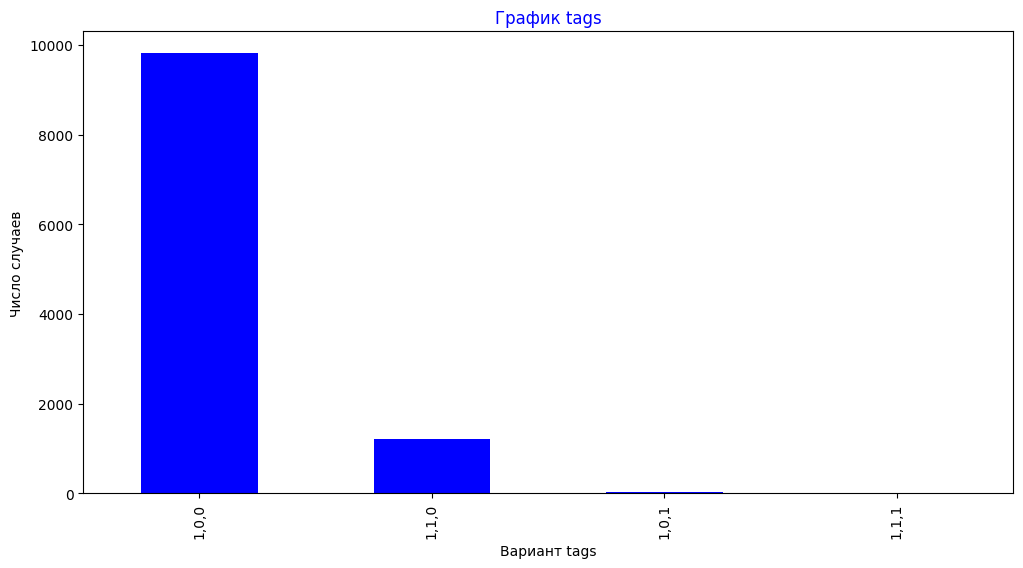

Порядок следования и расположения уникальных элементов (индексов) в строке


,tags
serial_number,
1,Дорожно-транспортные происшествия
2,ДТП и пострадавшие дети в возрасте до 16 лет
3,"ДТП и пострадавшие пешеходы, из-за наезда на п..."


Датафрейм событий по типу one hot encoding


,id,Дорожно-транспортные происшествия,ДТП и пострадавшие дети в возрасте до 16 лет,"ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов"
0,2525237,1,0,0
1,2060303,1,0,0
2,2624862,1,0,0
3,2624870,1,0,0
4,2536793,1,0,0


Информация о датафрейме событий по типу one hot encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 4 columns):
 #   Column                                                                                              Non-Null Count  Dtype
---  ------                                                                                              --------------  -----
 0   id                                                                                                  11064 non-null  int32
 1   Дорожно-транспортные происшествия                                                                   11064 non-null  int64
 2   ДТП и пострадавшие дети в возрасте до 16 лет                                                        11064 non-null  int64
 3   ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов  11064 non-null  int64
dtypes: int32(1), int64(3)
memory usage: 302.7 KB


None

,count,mean,std,min,25%,50%,75%,max
id,11064.0,2.297584e+06,325892.164673,2057598.0,2060363.75,2063129.5,2624954.25,2945928.0
Дорожно-транспортные происшествия,11064.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.00,1.0
ДТП и пострадавшие дети в возрасте до 16 лет,11064.0,1.100868e-01,0.313012,0.0,0.00,0.0,0.00,1.0
"ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов",11064.0,4.519161e-03,0.067076,0.0,0.00,0.0,0.00,1.0


Обработаем столбец nearby
ТОП-20 полученных значений


0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0    3451
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     759
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     371
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     362
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     287
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     173
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     159
0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     152
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

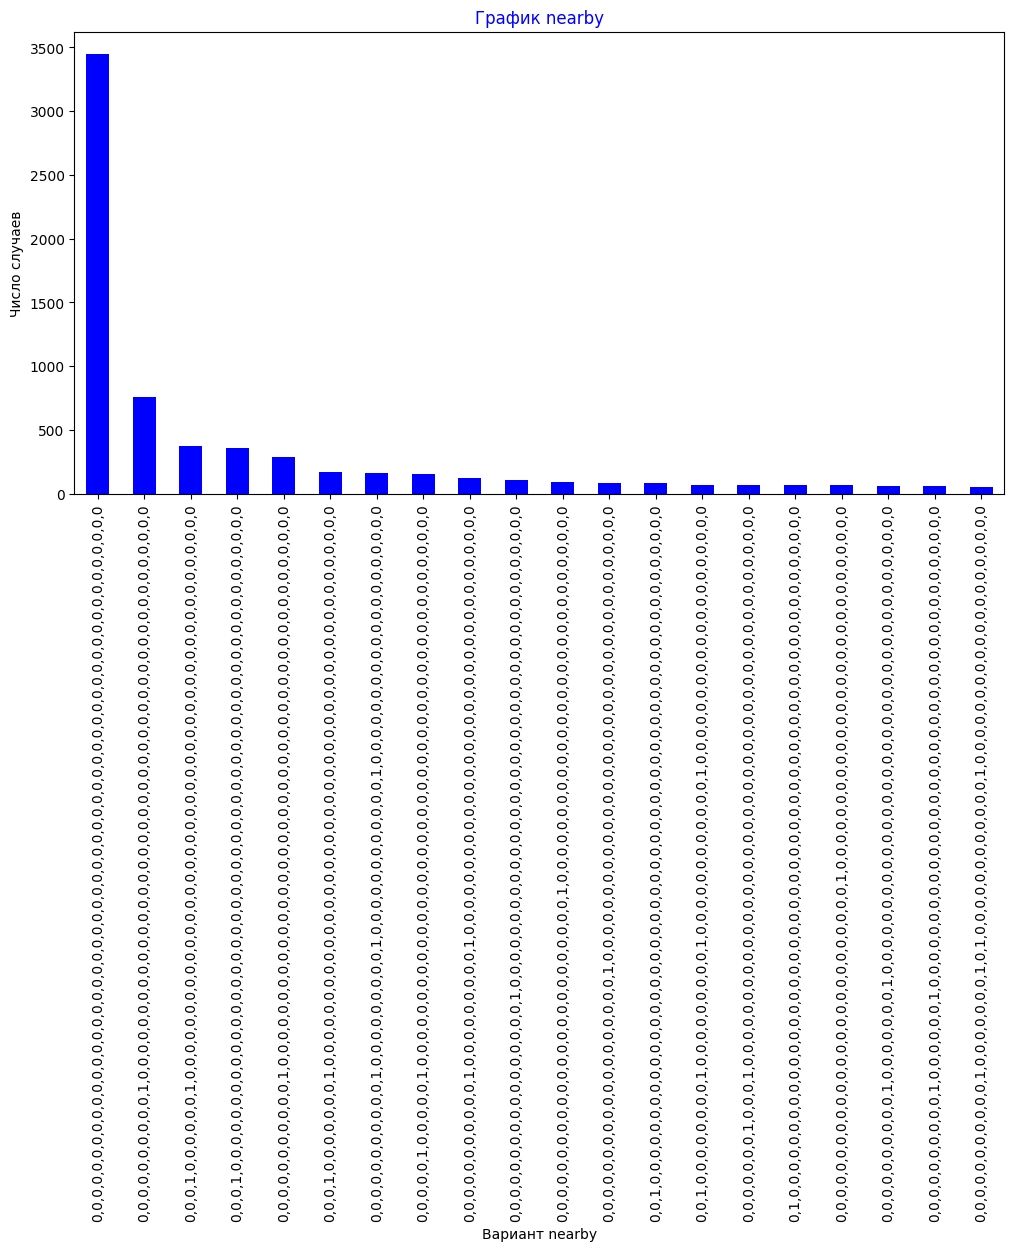

Порядок следования и расположения уникальных элементов (индексов) в строке


,nearby
serial_number,
1,NaN
2,АЗС
3,Административные здания
4,Нерегулируемый перекрёсток неравнозначных улиц (дорог)
5,Нерегулируемый пешеходный переход
6,Внутридворовая территория
7,Автостоянка (отделенная от проезжей части)
8,Выезд с прилегающей территории
9,Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)


Датафрейм событий по типу one hot encoding


,id,NaN,АЗС,Административные здания,Нерегулируемый перекрёсток неравнозначных улиц (дорог),Нерегулируемый пешеходный переход,Внутридворовая территория,Автостоянка (отделенная от проезжей части),Выезд с прилегающей территории,Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта),Медицинские (лечебные) организации,Жилые дома индивидуальной застройки,Многоквартирные жилые дома,"Тротуар, пешеходная дорожка",Автостоянка (не отделённая от проезжей части),...,Нерегулируемое пересечение с круговым движением,Лечебные учреждения,Пункт весового контроля,Остановка маршрутного такси,Нерегулируемый ж/д переезд,Территориальное подразделение МВД России (либо его структурное подразделение),Иное образовательное учреждение,Автовокзал (автостанция),"Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения",Иная образовательная организация,"Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации",Подземный пешеходный переход,Пешеходная зона,"Объект (здание, сооружение) религиозного культа","Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации"
0,2525237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2060303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2624862,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2624870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2536793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Информация о датафрейме событий по типу one hot encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 56 columns):
 #   Column                                                                                                                                         Non-Null Count  Dtype
---  ------                                                                                                                                         --------------  -----
 0   id                                                                                                                                             11064 non-null  int32
 1   nan                                                                                                                                            11064 non-null  int64
 2   АЗС                                                                                                                                            11064 

None

,count,mean,std,min,25%,50%,75%,max
id,11064.0,2.297584e+06,325892.164673,2057598.0,2060363.75,2063129.5,2624954.25,2945928.0
NaN,11064.0,0.000000e+00,0.000000,0.0,0.00,0.0,0.00,0.0
АЗС,11064.0,4.727043e-02,0.212226,0.0,0.00,0.0,0.00,1.0
Административные здания,11064.0,1.184020e-01,0.323098,0.0,0.00,0.0,0.00,1.0
Нерегулируемый перекрёсток неравнозначных улиц (дорог),11064.0,1.549168e-01,0.361842,0.0,0.00,0.0,0.00,1.0
Нерегулируемый пешеходный переход,11064.0,3.588214e-02,0.186005,0.0,0.00,0.0,0.00,1.0
Внутридворовая территория,11064.0,2.250542e-02,0.148327,0.0,0.00,0.0,0.00,1.0
Автостоянка (отделенная от проезжей части),11064.0,1.834779e-02,0.134212,0.0,0.00,0.0,0.00,1.0
Выезд с прилегающей территории,11064.0,4.040130e-02,0.196907,0.0,0.00,0.0,0.00,1.0
Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта),11064.0,6.534707e-02,0.247148,0.0,0.00,0.0,0.00,1.0


Обработаем столбец weather
ТОП-20 полученных значений


0,1,0,0,0,0,0,0,0    8195
1,0,0,0,0,0,0,0,0    1721
0,0,1,0,0,0,0,0,0     481
0,0,0,0,0,1,0,0,0     352
1,0,1,0,0,0,0,0,0      73
1,0,0,0,0,1,0,0,0      69
0,1,0,0,1,0,0,0,0      49
0,0,0,1,0,0,0,0,0      46
0,1,0,0,0,0,0,1,0      32
0,0,0,0,0,0,1,0,0      10
0,0,0,0,0,1,1,0,0      10
1,0,0,1,0,0,0,0,0       6
1,0,0,0,0,0,0,1,0       6
1,0,0,0,0,0,1,0,0       3
0,0,1,0,0,1,0,0,0       3
0,1,0,1,0,0,0,0,0       2
0,0,0,1,0,0,0,1,0       2
1,0,0,0,0,0,0,0,1       2
1,0,0,0,1,0,0,0,0       1
0,1,1,0,0,0,0,0,0       1
dtype: int64

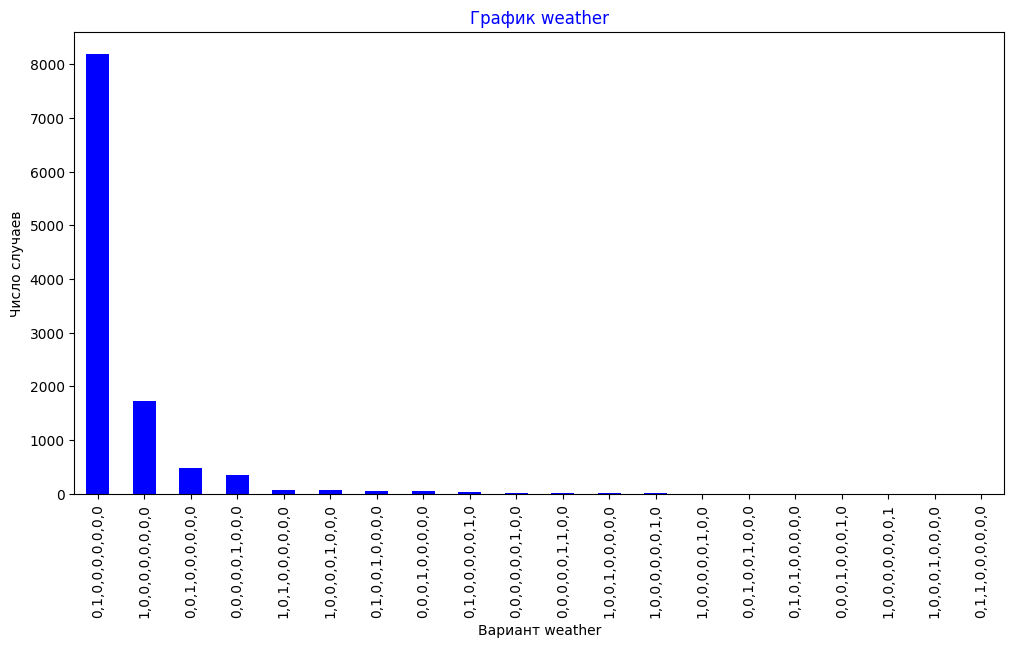

Порядок следования и расположения уникальных элементов (индексов) в строке


,weather
serial_number,
1,Пасмурно
2,Ясно
3,Дождь
4,Туман
5,Температура выше +30С
6,Снегопад
7,Метель
8,Температура ниже -30С
9,Ураганный ветер


Датафрейм событий по типу one hot encoding


,id,Пасмурно,Ясно,Дождь,Туман,Температура выше +30С,Снегопад,Метель,Температура ниже -30С,Ураганный ветер
0,2525237,1,0,0,0,0,0,0,0,0
1,2060303,0,1,0,0,0,0,0,0,0
2,2624862,0,1,0,0,0,0,0,0,0
3,2624870,0,1,0,0,0,0,0,0,0
4,2536793,0,1,0,0,0,0,0,0,0


Информация о датафрейме событий по типу one hot encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   id                     11064 non-null  int32
 1   Пасмурно               11064 non-null  int64
 2   Ясно                   11064 non-null  int64
 3   Дождь                  11064 non-null  int64
 4   Туман                  11064 non-null  int64
 5   Температура выше +30С  11064 non-null  int64
 6   Снегопад               11064 non-null  int64
 7   Метель                 11064 non-null  int64
 8   Температура ниже -30С  11064 non-null  int64
 9   Ураганный ветер        11064 non-null  int64
dtypes: int32(1), int64(9)
memory usage: 821.3 KB


None

,count,mean,std,min,25%,50%,75%,max
id,11064.0,2.297584e+06,325892.164673,2057598.0,2060363.75,2063129.5,2624954.25,2945928.0
Пасмурно,11064.0,1.700108e-01,0.375659,0.0,0.00,0.0,0.00,1.0
Ясно,11064.0,7.482827e-01,0.434019,0.0,0.00,1.0,1.00,1.0
Дождь,11064.0,5.043384e-02,0.218848,0.0,0.00,0.0,0.00,1.0
Туман,11064.0,5.061461e-03,0.070967,0.0,0.00,0.0,0.00,1.0
Температура выше +30С,11064.0,4.519161e-03,0.067076,0.0,0.00,0.0,0.00,1.0
Снегопад,11064.0,3.922632e-02,0.194142,0.0,0.00,0.0,0.00,1.0
Метель,11064.0,2.078814e-03,0.045549,0.0,0.00,0.0,0.00,1.0
Температура ниже -30С,11064.0,3.615329e-03,0.060022,0.0,0.00,0.0,0.00,1.0
Ураганный ветер,11064.0,1.807664e-04,0.013444,0.0,0.00,0.0,0.00,1.0


Обработаем столбец road_conditions
ТОП-20 полученных значений


1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0    6223
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     847
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     596
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     515
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     201
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     187
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     142
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     135
1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     129
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     118
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     111
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0      96
1,0,0,0,0,0,0,0,

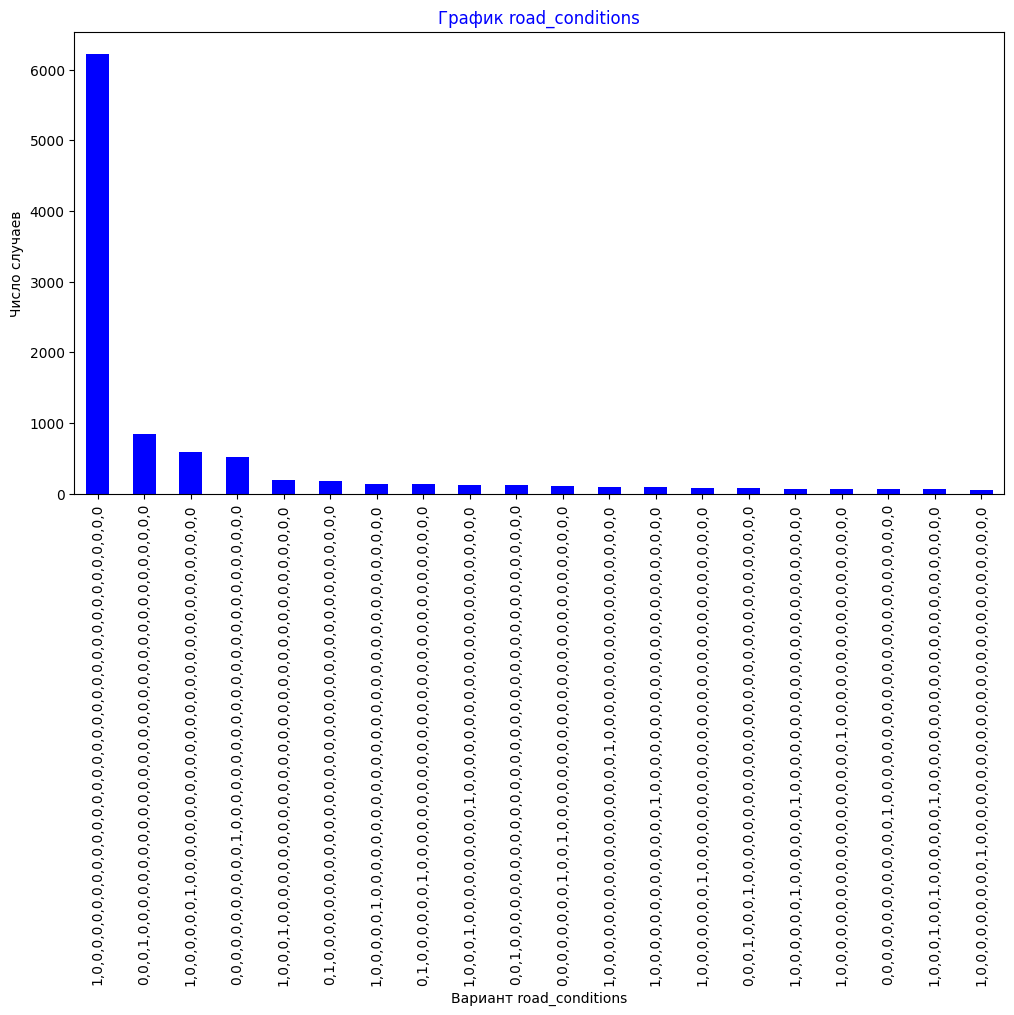

Порядок следования и расположения уникальных элементов (индексов) в строке


,road_conditions
serial_number,
1,Сухое
2,Со снежным накатом
3,Обработанное противогололедными материалами
4,Мокрое
5,Отсутствие дорожных знаков в необходимых местах
6,Неудовлетворительное состояние обочин
7,Отсутствие освещения
8,"Отсутствие, плохая различимость горизонтальной разметки проезжей части"
9,Недостатки зимнего содержания


Датафрейм событий по типу one hot encoding


,id,Сухое,Со снежным накатом,Обработанное противогололедными материалами,Мокрое,Отсутствие дорожных знаков в необходимых местах,Неудовлетворительное состояние обочин,Отсутствие освещения,"Отсутствие, плохая различимость горизонтальной разметки проезжей части",Недостатки зимнего содержания,Неисправное освещение,Дефекты покрытия,Заснеженное,Иные недостатки,Гололедица,...,Отсутствие временных ТСОД в местах проведения работ,Залитое (покрытое) водой,Нарушения в размещении наружной рекламы,Загрязненное,Пыльное,Отсутствие дорожных ограждений в необходимых местах,"Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств",Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Неисправность светофора,Не установлено,Несоответствие железнодорожного переезда предъявляемым требованиям,Свежеуложенная поверхностная обработка,Несоответствие дорожных ограждений предъявляемым требованиям,"Отсутствие, плохая различимость вертикальной разметки",Низкие сцепные качества покрытия
0,2525237,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2060303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2624862,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2624870,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2536793,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Информация о датафрейме событий по типу one hot encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 38 columns):
 #   Column                                                                                         Non-Null Count  Dtype
---  ------                                                                                         --------------  -----
 0   id                                                                                             11064 non-null  int32
 1   Сухое                                                                                          11064 non-null  int64
 2   Со снежным накатом                                                                             11064 non-null  int64
 3   Обработанное противогололедными материалами                                                    11064 non-null  int64
 4   Мокрое                                                                                         11

None

,count,mean,std,min,25%,50%,75%,max
id,11064.0,2.297584e+06,325892.164673,2057598.0,2060363.75,2063129.5,2624954.25,2945928.0
Сухое,11064.0,7.686189e-01,0.421734,0.0,1.00,1.0,1.00,1.0
Со снежным накатом,11064.0,3.443601e-02,0.182355,0.0,0.00,0.0,0.00,1.0
Обработанное противогололедными материалами,11064.0,1.364787e-02,0.116029,0.0,0.00,0.0,0.00,1.0
Мокрое,11064.0,1.032176e-01,0.304257,0.0,0.00,0.0,0.00,1.0
Отсутствие дорожных знаков в необходимых местах,11064.0,6.182213e-02,0.240843,0.0,0.00,0.0,0.00,1.0
Неудовлетворительное состояние обочин,11064.0,8.315257e-03,0.090812,0.0,0.00,0.0,0.00,1.0
Отсутствие освещения,11064.0,3.398409e-02,0.181196,0.0,0.00,0.0,0.00,1.0
"Отсутствие, плохая различимость горизонтальной разметки проезжей части",11064.0,1.008677e-01,0.301167,0.0,0.00,0.0,0.00,1.0
Недостатки зимнего содержания,11064.0,4.311280e-02,0.203120,0.0,0.00,0.0,0.00,1.0


Обработаем столбец participant_categories
ТОП-20 полученных значений


0,1,0,0,0,0    6551
1,1,0,0,0,0    2217
0,1,1,0,0,0     793
0,1,0,1,0,0     567
1,1,0,1,0,0     448
0,1,0,0,1,0     213
0,1,0,1,1,0     114
0,1,1,1,0,0      65
1,1,1,0,0,0      50
1,1,1,1,0,0      16
0,1,0,0,0,1      10
0,1,1,0,1,0      10
0,1,1,1,1,0       5
1,1,0,1,1,0       2
1,1,0,0,0,1       2
0,1,0,1,0,1       1
dtype: int64

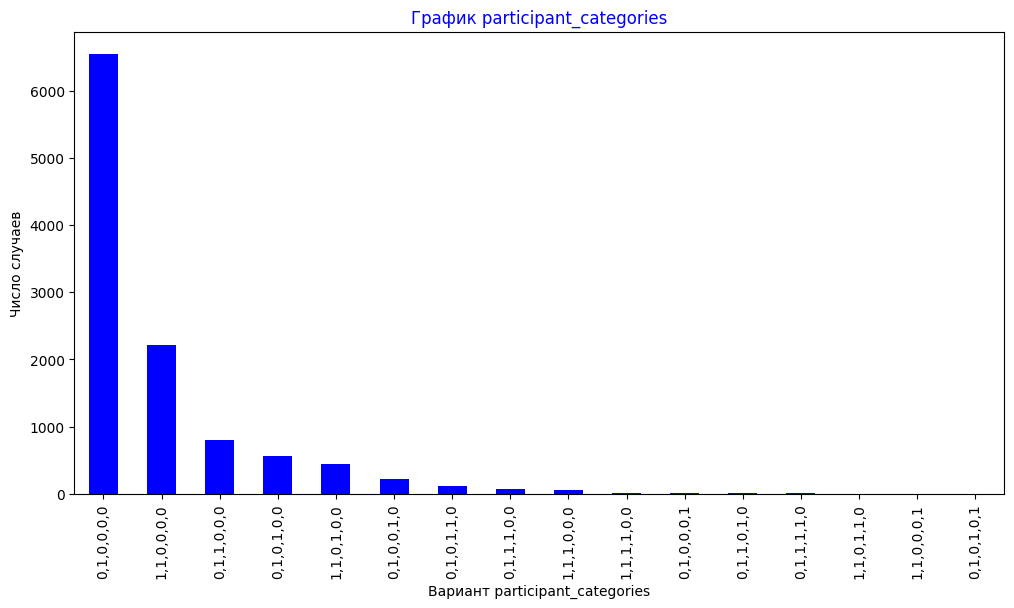

Порядок следования и расположения уникальных элементов (индексов) в строке


,participant_categories
serial_number,
1,Пешеходы
2,Все участники
3,Мотоциклисты
4,Дети
5,Велосипедисты
6,Общ. транспорт


Датафрейм событий по типу one hot encoding


,id,Пешеходы,Все участники,Мотоциклисты,Дети,Велосипедисты,Общ. транспорт
0,2525237,1,1,0,0,0,0
1,2060303,0,1,0,0,0,0
2,2624862,0,1,0,0,0,0
3,2624870,0,1,0,0,0,0
4,2536793,0,1,0,0,0,0


Информация о датафрейме событий по типу one hot encoding
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              11064 non-null  int32
 1   Пешеходы        11064 non-null  int64
 2   Все участники   11064 non-null  int64
 3   Мотоциклисты    11064 non-null  int64
 4   Дети            11064 non-null  int64
 5   Велосипедисты   11064 non-null  int64
 6   Общ. транспорт  11064 non-null  int64
dtypes: int32(1), int64(6)
memory usage: 562.0 KB


None

,count,mean,std,min,25%,50%,75%,max
id,11064.0,2.297584e+06,325892.164673,2057598.0,2060363.75,2063129.5,2624954.25,2945928.0
Пешеходы,11064.0,2.471981e-01,0.431402,0.0,0.00,0.0,0.00,1.0
Все участники,11064.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.00,1.0
Мотоциклисты,11064.0,8.486985e-02,0.278701,0.0,0.00,0.0,0.00,1.0
Дети,11064.0,1.100868e-01,0.313012,0.0,0.00,0.0,0.00,1.0
Велосипедисты,11064.0,3.109183e-02,0.173574,0.0,0.00,0.0,0.00,1.0
Общ. транспорт,11064.0,1.174982e-03,0.034259,0.0,0.00,0.0,0.00,1.0


In [ ]:
for i in roll_of_lists[1:]:
  converting_columns_with_lists(df, i)


Можем увидеть, что:
- наибольшее количество происшествий - около 91% произошли без отягощающих обстоятельств - без детей и пешеходов.
- наибольшее количество проишествий произошло при ясной погоде.  
В тройку лидеров также попали происшествия при пасмурной погоде и при дожде.   
Также визуализируются ДТП при снегопаде.  
Но такое распределение больше говорит о количеств дней с такой погодой а не о зависимости частоты ДТП от конкретной погоды.  
Также целесообразно будет рассмотреть тяжесть происшествий в зависимости от погодных условий
- для более половины всех происшествий не указаны какие-либо ориентиры или объекты, вблизи которых они произошли. Среди уакзанных наиболее часто встречаются нерегулируемые перекрестки вблизи жилых домов индивидуальной застройки и жилых многоквартирных домов. ДТП около могокрартирных жилых домов втстечаются довольно частов ТОП-20 объектов, из чего можно предположить, что ДТП чаще фиксируются в границах городов.
- ДТП чаще всего и с большим отрывом зафиксированы на сухом покрытии. Далее по частоте встречаются мокрое покрытие, отсутствие разметки на сухом покрытии и заснеженное покрытие. Сказанное не дает оснований утверждать , что сухое покрытие более способствует совершению ДТП.
- в списоке значений категорий участников отсутствуют водители и пассажиры, что дает нам основания предположить, что категория "Все участники" предполагает как раз категори. "Водители и пассажиры". Исходя из этого видим, чт последняя категория ниаболее часто присутствует в ДТП. Две следующик строчки приходятся на водителейй+пешеходов и на мотощиклистов + пешеходов


Выведем на экран первые строки всех сохраненных нами файлов в формате `.pickle`

In [ ]:
os.listdir()
for i in range(len(os.listdir())):
  if "_ohe.pickle" in os.listdir()[i]:
    print('\033[94m''Файл ', os.listdir()[i],'\033[0m')
    with open(os.listdir()[i], 'rb') as file:
        weather_ohe_reload = pickle.load(file)
    display(weather_ohe_reload.head())

Файл  participant_cat_ohe.pickle 


,id,Пешеходы,Все участники,Мотоциклисты,Дети,Велосипедисты,Общ. транспорт
0,2525237,1,1,0,0,0,0
1,2060303,0,1,0,0,0,0
2,2624862,0,1,0,0,0,0
3,2624870,0,1,0,0,0,0
4,2536793,0,1,0,0,0,0


Файл  violations_ohe.pickle 


,id,Нарушение правил проезда пешеходного перехода,Другие нарушения ПДД водителем,NaN,Неправильный выбор дистанции,"Выезд на полосу встречного движения в местах, где это запрещено",Несоблюдение требований ОСАГО,Несоблюдение очередности проезда,Выезд на полосу встречного движения,Управление ТС в состоянии алкогольного опьянения,Нарушение правил расположения ТС на проезжей части,Нарушение правил перевозки детей (не использование детских сидений либо удерживающих устройств),Несоблюдение бокового интервала,Нарушение правил применения мотошлема,Нарушение правил перестроения,...,Нахождение на проезжей части без цели её перехода,Пешеход в состоянии алкогольного опьянения,Движение вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины,Отсутствие световозвращающих элементов,Неожиданный выход из-за ТС,Переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка),Неожиданный выход из-за сооружений (деревьев),Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода,Неожиданный выход из-за стоящего ТС,Переход проезжей части в запрещённом месте (оборудованном пешеходными ограждениями),Движение вдоль проезжей части при наличии и удовлетворительном состоянии тротуара,Ходьба вдоль проезжей части при наличии и удовлетворительном состоянии тротуара,Пешеход в возрасте до 7 лет без взрослого,Ходьба вдоль проезжей части попутного направления вне населенного пункта при удовлетворительном состоянии обочины,Неподчинение сигналам регулирования
0,2446450,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2447793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2447793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2447793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2447793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Файл  tags_ohe.pickle 


,id,Дорожно-транспортные происшествия,ДТП и пострадавшие дети в возрасте до 16 лет,"ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов"
0,2525237,1,0,0
1,2060303,1,0,0
2,2624862,1,0,0
3,2624870,1,0,0
4,2536793,1,0,0


Файл  weather_ohe.pickle 


,id,Пасмурно,Ясно,Дождь,Туман,Температура выше +30С,Снегопад,Метель,Температура ниже -30С,Ураганный ветер
0,2525237,1,0,0,0,0,0,0,0,0
1,2060303,0,1,0,0,0,0,0,0,0
2,2624862,0,1,0,0,0,0,0,0,0
3,2624870,0,1,0,0,0,0,0,0,0
4,2536793,0,1,0,0,0,0,0,0,0


Файл  nearby_ohe.pickle 


,id,NaN,АЗС,Административные здания,Нерегулируемый перекрёсток неравнозначных улиц (дорог),Нерегулируемый пешеходный переход,Внутридворовая территория,Автостоянка (отделенная от проезжей части),Выезд с прилегающей территории,Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта),Медицинские (лечебные) организации,Жилые дома индивидуальной застройки,Многоквартирные жилые дома,"Тротуар, пешеходная дорожка",Автостоянка (не отделённая от проезжей части),...,Нерегулируемое пересечение с круговым движением,Лечебные учреждения,Пункт весового контроля,Остановка маршрутного такси,Нерегулируемый ж/д переезд,Территориальное подразделение МВД России (либо его структурное подразделение),Иное образовательное учреждение,Автовокзал (автостанция),"Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения",Иная образовательная организация,"Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации",Подземный пешеходный переход,Пешеходная зона,"Объект (здание, сооружение) религиозного культа","Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации"
0,2525237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2060303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2624862,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2624870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2536793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Файл  road_conditions_ohe.pickle 


,id,Сухое,Со снежным накатом,Обработанное противогололедными материалами,Мокрое,Отсутствие дорожных знаков в необходимых местах,Неудовлетворительное состояние обочин,Отсутствие освещения,"Отсутствие, плохая различимость горизонтальной разметки проезжей части",Недостатки зимнего содержания,Неисправное освещение,Дефекты покрытия,Заснеженное,Иные недостатки,Гололедица,...,Отсутствие временных ТСОД в местах проведения работ,Залитое (покрытое) водой,Нарушения в размещении наружной рекламы,Загрязненное,Пыльное,Отсутствие дорожных ограждений в необходимых местах,"Сужение проезжей части, наличие препятствий, затрудняющих движение транспортных средств",Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям,Неисправность светофора,Не установлено,Несоответствие железнодорожного переезда предъявляемым требованиям,Свежеуложенная поверхностная обработка,Несоответствие дорожных ограждений предъявляемым требованиям,"Отсутствие, плохая различимость вертикальной разметки",Низкие сцепные качества покрытия
0,2525237,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2060303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2624862,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2624870,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2536793,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Файл  participant_categories_ohe.pickle 


,id,Пешеходы,Все участники,Мотоциклисты,Дети,Велосипедисты,Общ. транспорт
0,2525237,1,1,0,0,0,0
1,2060303,0,1,0,0,0,0
2,2624862,0,1,0,0,0,0
3,2624870,0,1,0,0,0,0
4,2536793,0,1,0,0,0,0


Поскольку на текущем этапе датафрейм weather_ohe_reload нам не нужен, удалим его из тетрадки

In [ ]:
del weather_ohe_reload

Сохраним созданный датафрейм на диск в формате `.pickle`

### 4.5. Графики

In [ ]:
#weather_plot

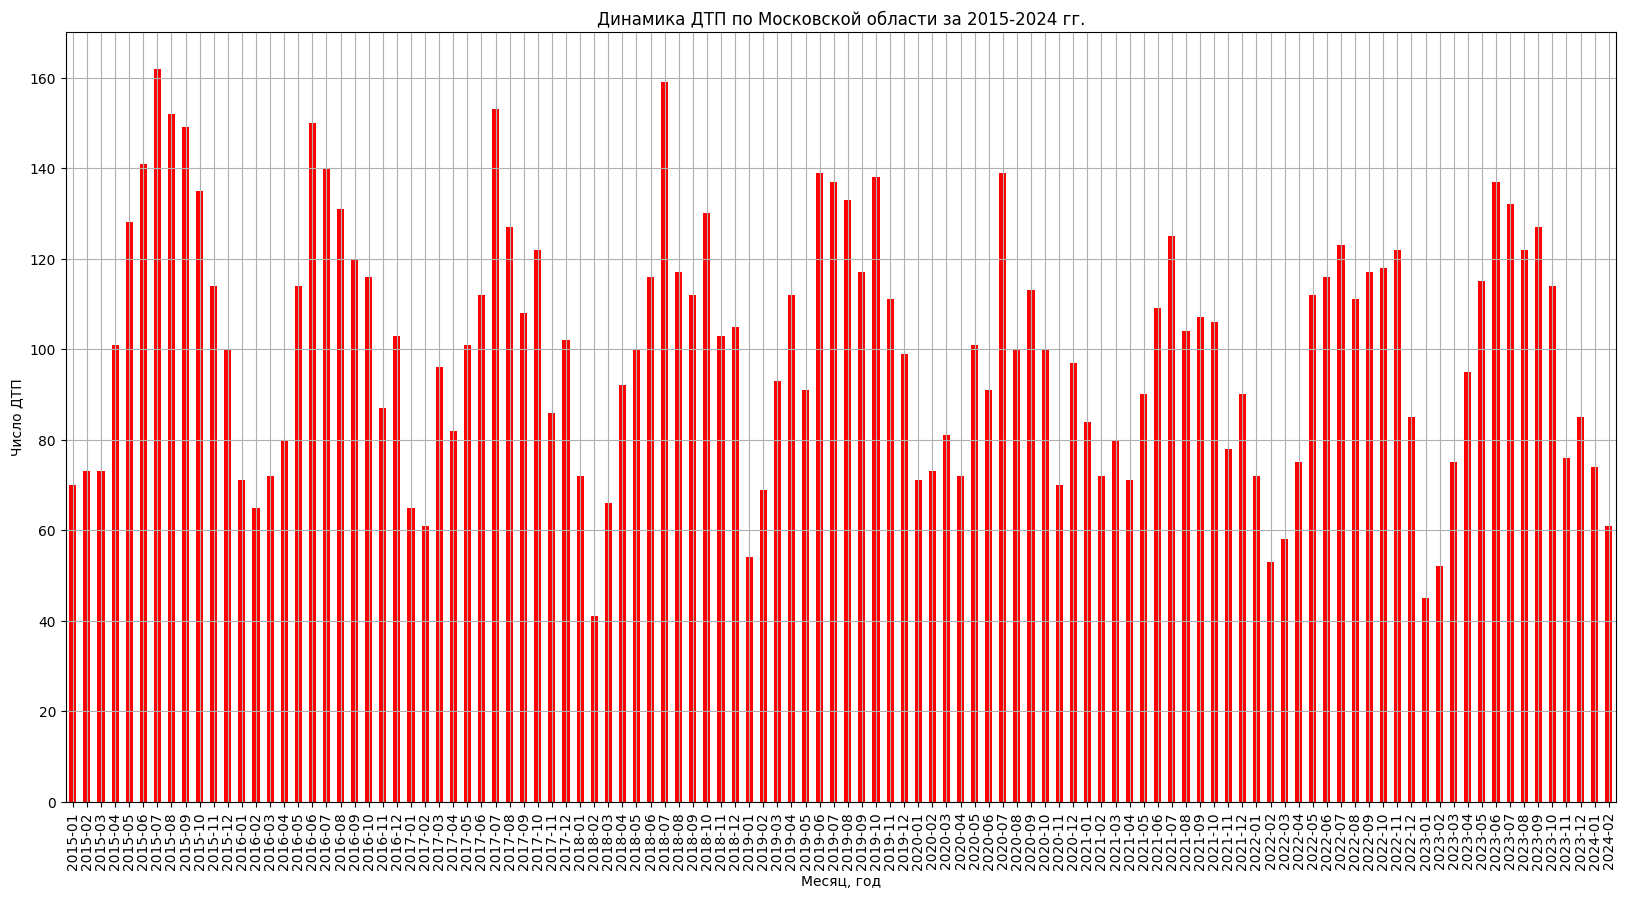

In [ ]:
# Посмотрим число ДТП по месяцам.

weather_plot = df['datetime'].dt.to_period("M").sort_values().value_counts(
    sort=False)
weather_plot.plot(kind='bar', grid=True, figsize=[20, 10],color = 'red')
plt.title('Динамика ДТП по Московской области за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

Видна четкая сезонность, и нисходящий тренд по числу ДТП. Похоже, сотрудники ГИБДД не зря едят свой хлеб, но, возможно, это связано с качеством дорог, разметке, качеством авто, законодательной базой. Здесь можно сделать множество предположений. Также можно предположить, что большая часть водителей реже пользуются автомобилями или не пользуются совсем. В летний период увеличивается число водителей-путешественников.

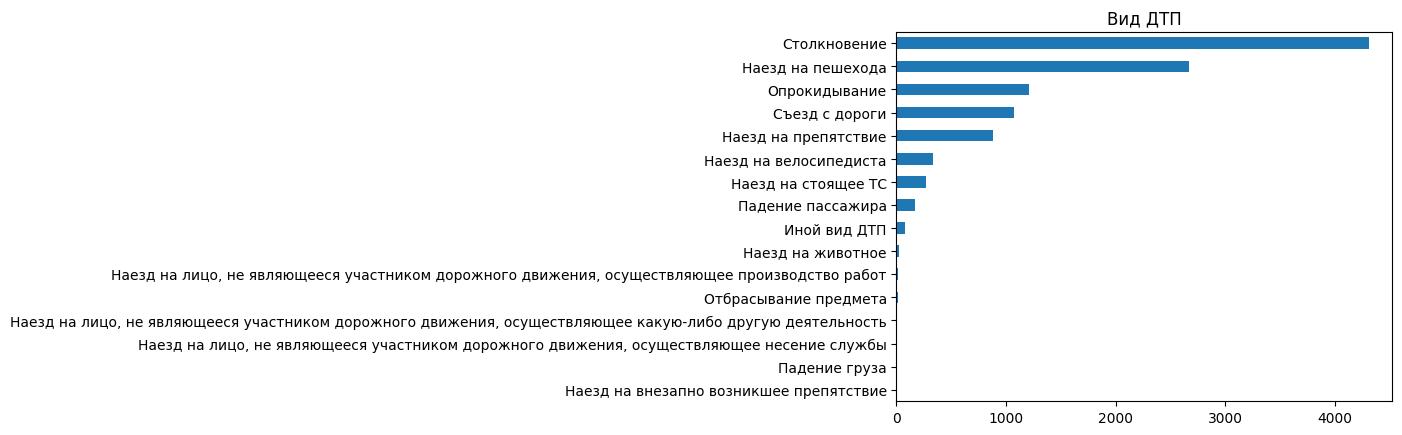

In [ ]:
df['category'].value_counts(ascending = True).plot(kind = 'barh')
plt.title('Вид ДТП');

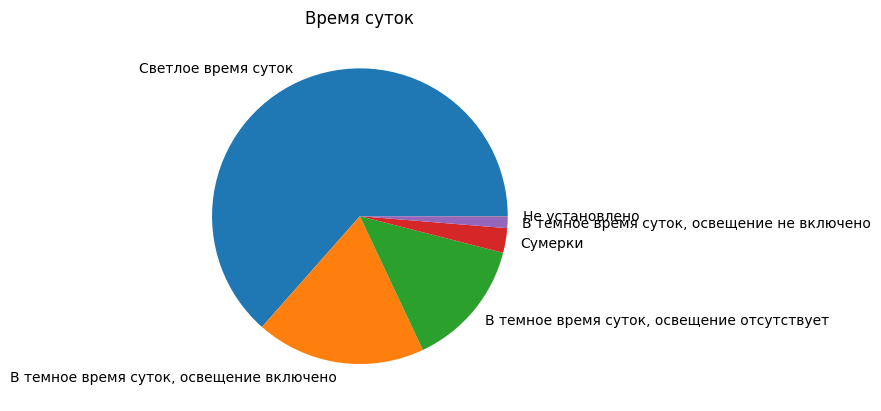

In [ ]:
df['light'].value_counts().plot(kind = 'pie', label = '');
plt.title('Время суток');

В светлое время суток чаще ездят, освещение присутствует на крупных магистралях, где более интенсивное движение. Но стоит отметить дороги, где нет освещения. Можно посмотреть категории ДТП в зависимости от типа освещения. Здесь можно провести кластеризацию.(еще один пет-проект, увязывая на тип ДТП).

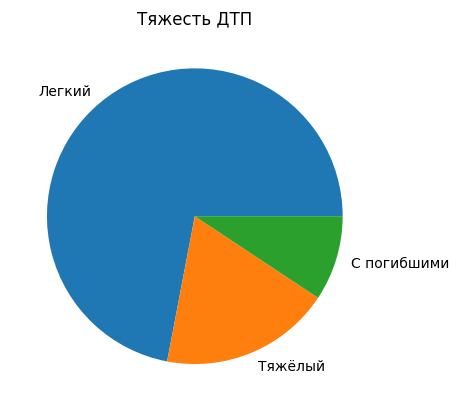

In [ ]:
# Посмотрим тяжесть ДТП.

df['severity'].value_counts().plot(kind = 'pie', label = '')
plt.title('Тяжесть ДТП');

In [ ]:
# Процентное соотношение.

df['severity'].value_counts(normalize= True).round(2)*100

Легкий         72.0
Тяжёлый        19.0
С погибшими     9.0
Name: severity, dtype: float64

Почти 2/3 ДТП - являются тяжелыми (есть раненные и с погибшие).

In [ ]:
# Посмотрим число погибших.

dead_df = df[['datetime','dead_count', 'injured_count']].copy()

dead_df['datetime_M'] = dead_df['datetime'].dt.to_period("M")

dead_df=dead_df.sort_values(by = ['datetime_M'])

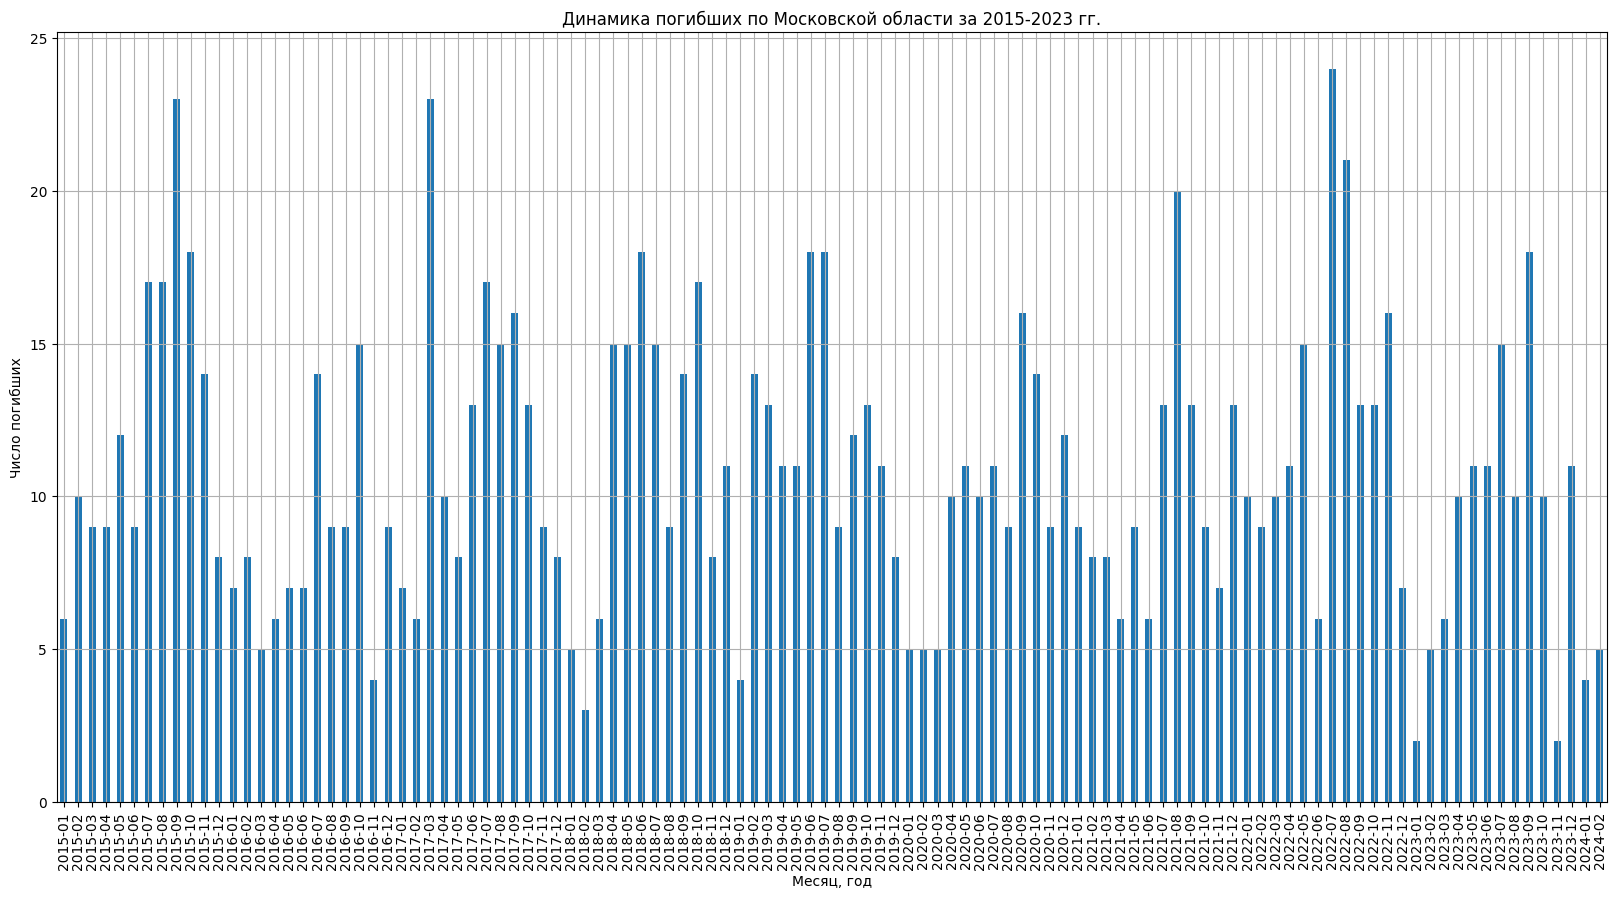

In [ ]:
dead_df.groupby('datetime_M')['dead_count'].sum().plot(kind='bar',
                                                       grid=True,
                                                       figsize=[20, 10]
                                                      )

plt.title('Динамика погибших по Московской области за 2015-2023 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число погибших');

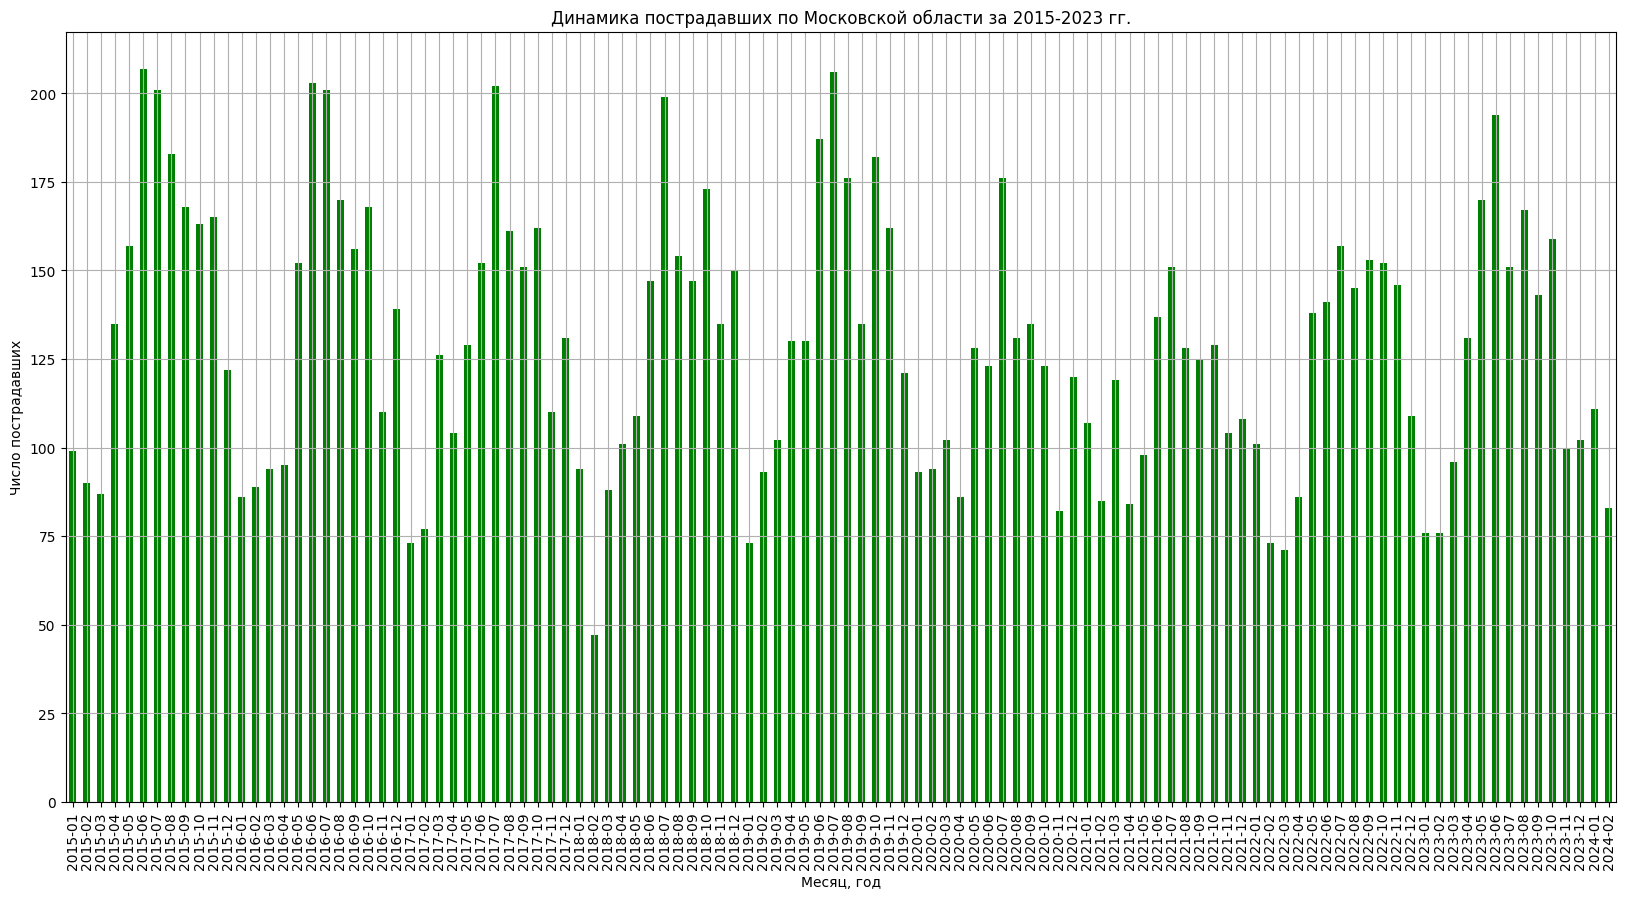

In [ ]:
# Смотрим число пострадавших.

dead_df.groupby('datetime_M')['injured_count'].sum().plot(kind='bar',
                                                          grid=True,
                                                          color = 'green',
                                                          figsize=[20, 10])

plt.title('Динамика пострадавших по Московской области за 2015-2023 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число пострадавших');

Как видим количество ДТП, погибших и пострадавших имеют тенденцию к снижению, четкую сезонность. Дальнейшую обработку данных можно делать на ваше усмотрение.)))

Удалим ненужные нам сейчас дадафреймы

In [ ]:
del df
del df_vehicles
del df_vehicles_participants
del df_footer
del df_foot_part

# 5 Обработаем все имеющиеся файлы
Выше мы произвели обработку одного из скачанных файлов.  
На основе созданного кода обработаем все имеющиеся файлы и соединим их и создадим на выходе три сводных датафрейма:
- собственно ДТП
- автомобили, участвовавшие в ДТП
- водители, пассажиры и пешеходы, участвовавшие в ДПТ

Вызовем функцию `return_true_dfs`, которая вернет нам обработанные датафреймы

#### Сформируем датафрейм `data_base`  - собственно ДТП

In [ ]:
data_base = pd.DataFrame()

for path in tqdm(list_file):
    data_base = pd.concat([data_base, return_true_dfs(path, 1)]).reset_index(drop=True)

100%|██████████| 85/85 [08:20<00:00,  5.89s/it]


In [ ]:
# Назначим индексы заново
data_base = data_base.reset_index(drop = True)

In [ ]:
# удалим лишние пробелы и для заполнения пропущенных значений
# заполнем пропущенные значений строкой "Не заполнено"и присвоим данным тип category
lower_and_strip(data_base, ["light", "category","severity","parent_region"])

In [ ]:
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411646 entries, 0 to 1411645
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   coordinates             1411646 non-null  object        
 1   id                      1411646 non-null  int32         
 2   tags                    1411646 non-null  object        
 3   light                   1411646 non-null  category      
 4   lat                     1400902 non-null  float64       
 5   long                    1400902 non-null  float64       
 6   nearby                  1411646 non-null  object        
 7   region                  1411646 non-null  object        
 8   address                 1344868 non-null  object        
 9   weather                 1411646 non-null  object        
 10  category                1411646 non-null  category      
 11  datetime                1411646 non-null  datetime64[ns]
 12  severity      

In [ ]:
# Сохраним созданный датафрейм на диск
with open("data_base.pickle", "wb") as file:
    pickle.dump(data_base, file)

In [ ]:
# Вызовем в тетрадку файл с базой ДТП

with open("data_base.pickle", 'rb') as file:
    data_base = pickle.load(file)

##### В датафрейме data_base обработаем столбцы со списками
В датафрейме data_base обработаем столбцы 'tags', 'nearby', 'weather', 'road_conditions', 'participant_categories'  
Выгрузим файлы на диск:
- tags_ohe.pickle
- nearby_ohe.pickle
- weather_ohe.pickle
- road_conditions_ohe.pickle
- participant_categories_ohe.pickle


In [ ]:
for i in tqdm(roll_of_lists[1:]):
  converting_columns_with_lists(data_base, i)


In [ ]:
# Удалим датафрейм из тетрадки
del data_base

#### Сформируем датафрейм `data_vehicles`  - автомобили, участвовавшие в ДТП

In [ ]:
data_vehicles = pd.DataFrame()

for path in tqdm(list_file):
    data_vehicles = pd.concat([data_vehicles,return_true_dfs(path, 2)]).reset_index(drop=True)

100%|██████████| 85/85 [04:57<00:00,  3.50s/it]


In [ ]:
# Назначим индексы заново
data_vehicles = data_vehicles.reset_index(drop = True)


In [ ]:
# удалим лишние пробелы и для заполнения пропущенных значений
# заполнем пропущенные значений строкой "Не заполнено"и присвоим данным тип category
lower_and_strip(data_vehicles, list_category_vehicles)

In [ ]:
data_vehicles.info()

In [ ]:
# Сохраним созданный датафрейм на диск
with open("data_vehicles.pickle", "wb") as file:
    pickle.dump(data_vehicles, file)

In [ ]:
# Удамим датафрейм из тетрадки
del data_vehicles

#### Сформируем датафрейм `data_foot_part`  - водители, пассажиры и пешеходы, участвовавшие в ДПТ

In [ ]:
data_foot_part = pd.DataFrame()

for path in tqdm(list_file):
    data_foot_part = pd.concat([data_foot_part,return_true_dfs(path, 3)])
#data_foot_part = data_foot_part.reset_index(drop = True)

100%|██████████| 85/85 [06:40<00:00,  4.71s/it]


In [ ]:
# Назначим индексы заново
data_foot_part = data_foot_part.reset_index(drop = True)


В датафрейме присутствуют записи, в которых ячейки во всех столбцах, кроме столбца `id` - пустые.  
Сохраним датафрейм без таких записей.

In [ ]:
#L = data_foot_part.index[data_foot_part.isna().all(axis=1)].tolist()
#alternative, if huge dataframe slowier
L = data_foot_part[data_foot_part.isna().all(axis=1)].index.tolist()
print (L)

[]


In [ ]:
data_foot_part[data_foot_part.drop(columns=('id')).isna().all(axis=1)]

,id,role,gender,violations,health_status,years_of_driving_experience


In [ ]:
# Сохраним датафрейм без записей, в которых ячейки во всех столбцах, кроме столбца id - пустые.
data_foot_part = data_foot_part[~data_foot_part.drop(columns=('id')).isna().all(axis=1)].copy().reset_index(drop = True)

In [ ]:
# удалим лишние пробелы и для заполнения пропущенных значений
# заполнем пропущенные значений строкой "Не заполнено"и присвоим данным тип category

lower_and_strip(data_foot_part, ['role',	'gender',	'health_status'])

In [ ]:
# Заменим в столбце index отсутствующие значения на "Не заполнено"
data_foot_part.years_of_driving_experience = data_foot_part.years_of_driving_experience.fillna('Не заполнено')

In [ ]:
# Проверим количество отсутствующих данных
data_foot_part.isna().mean()*100

id                             0.0
role                           0.0
gender                         0.0
violations                     0.0
health_status                  0.0
years_of_driving_experience    0.0
dtype: float64

In [ ]:
data_foot_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466960 entries, 0 to 3466959
Data columns (total 6 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   id                           int32   
 1   role                         category
 2   gender                       category
 3   violations                   object  
 4   health_status                category
 5   years_of_driving_experience  object  
dtypes: category(3), int32(1), object(2)
memory usage: 76.0+ MB


In [ ]:
# Сохраним созданный датафрейм на диск
with open("data_foot_part.pickle", "wb") as file:
    pickle.dump(data_foot_part, file)

##### В датафрейме df_foot_part обработаем столбцы со списками
В датафрейме data_vehicles обработаем столбцы 'violations'.   
Выгрузим файлы на диск:
- violations_ohe.pickle



In [ ]:
def converting_columns_with_lists(df, col_name):
  print('\033[95m''\033[1m'f'Обработаем столбец {col_name}''\033[0m')
  # Создадим список, который будет ключом к индексам, полученным из данных трансформируемого столбца
  weather_list = list(df.explode(col_name)[col_name].unique())
  #print(weather_list)

  # Создадим функцию по переводу списка в датафрейм, где каждой записи (каждому событию ДТП) будет соответствовать
  # "переключатель" 0 или 1 в зависимости от наличия одного или нескольких уникальных элементов, входящих в списки столбца
  def return_w(row, param, col_list):
    # Индекс в строке будет соответсвовать номеру в списке.
    # 0 - нет признака, 1 есть признак.
    # Создадим список из 0 в строчном формате.
    number_list = ['0' for i in range(len(col_list))]

    # Если значение в строке больше нуля то заменяем 0 значением 1 по индексу
    #print('\033[95m''row[param]''\033[0m', row[param], 'param ', param, 'row  ', row)
    if len(row[param]) >0:
        index_list = [col_list.index(i) for i in row[param]]
        for ind in index_list:
            number_list[ind] = '1'

    # Возвращаем данные в виде строки, разделенной запятыми.
    return ','.join(number_list)

  # Посчитаем полученные значения.
  weather_df_count = df.apply(return_w, axis=1, args=(col_name, weather_list,)).value_counts()
  weather_df_count_head_20 = weather_df_count.head(20).copy()
  print('\033[94m''ТОП-20 полученных значений''\033[0m')
  display(weather_df_count_head_20)

  # Построим график.

  plt.figure(figsize=(12,6))
  weather_df_count_head_20.plot(kind='bar', grid=False, color = 'blue')
  plt.title(f'График {col_name}', color = 'b')
  plt.xlabel(f'Вариант {col_name}')
  plt.ylabel('Число случаев')
  plt.show()

  # Визуализируем порядок следования и расположения уникальных элементов (индексов) в строке
  weather_list_df = pd.DataFrame({'serial_number': list(range(1,len(weather_list)+1)),
                                col_name: weather_list})\
                                .set_index('serial_number')
  print('\033[94m''Порядок следования и расположения уникальных элементов (индексов) в строке''\033[0m')
  display(weather_list_df)

  if col_name == 'violations':
    return

  # Подготовим датафрейм содержащий id событий. Он понадобится нам для формирования датафрейма событий по типу one hot encoding.
  weather_ohe = pd.DataFrame()
  weather_ohe['id'] = df['id'].copy()

  # Создадим датафрейма событий по типу one hot encoding.
  weather_ohe[weather_list] = df.apply(return_w, axis=1, args=(col_name, weather_list,)
                                     ).str.split(',', expand=True).astype(int)

  pd.set_option('display.max_colwidth', None)
  print('\033[94m''Датафрейм событий по типу one hot encoding''\033[0m')
  display(weather_ohe.head())
  #pd.reset_option('display.max_colwidth')
  print('\033[94m''Информация о датафрейме событий по типу one hot encoding''\033[0m')
  display(weather_ohe.info())

  # Изменим тип данных для столбцов и установим его int8
  change_type(weather_ohe, weather_ohe.columns[1:], 'int8')

    # Посмотрим описательные статистики.

  display(weather_ohe.describe().T)

  # Сохраним созданный датафрейм на диск в формате `.pickle`
  # в переменную dim созраним окончание и расширение создаваемого файла
  dim = '_ohe.pickle'
  #for i in range(len(df.columns)):
  # создадим имя сохраняемого файла
  pickle_file_name = col_name+dim
  # Сохраним созданный датафрейм на диск
  with open(pickle_file_name, "wb") as file:
      pickle.dump(weather_ohe, file)
  #print(df.columns[i]+dim)

  return(weather_ohe)

Обработаем столбец violations
ТОП-20 полученных значений


0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0    1774894
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0     130892
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0      86564
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0      86252
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

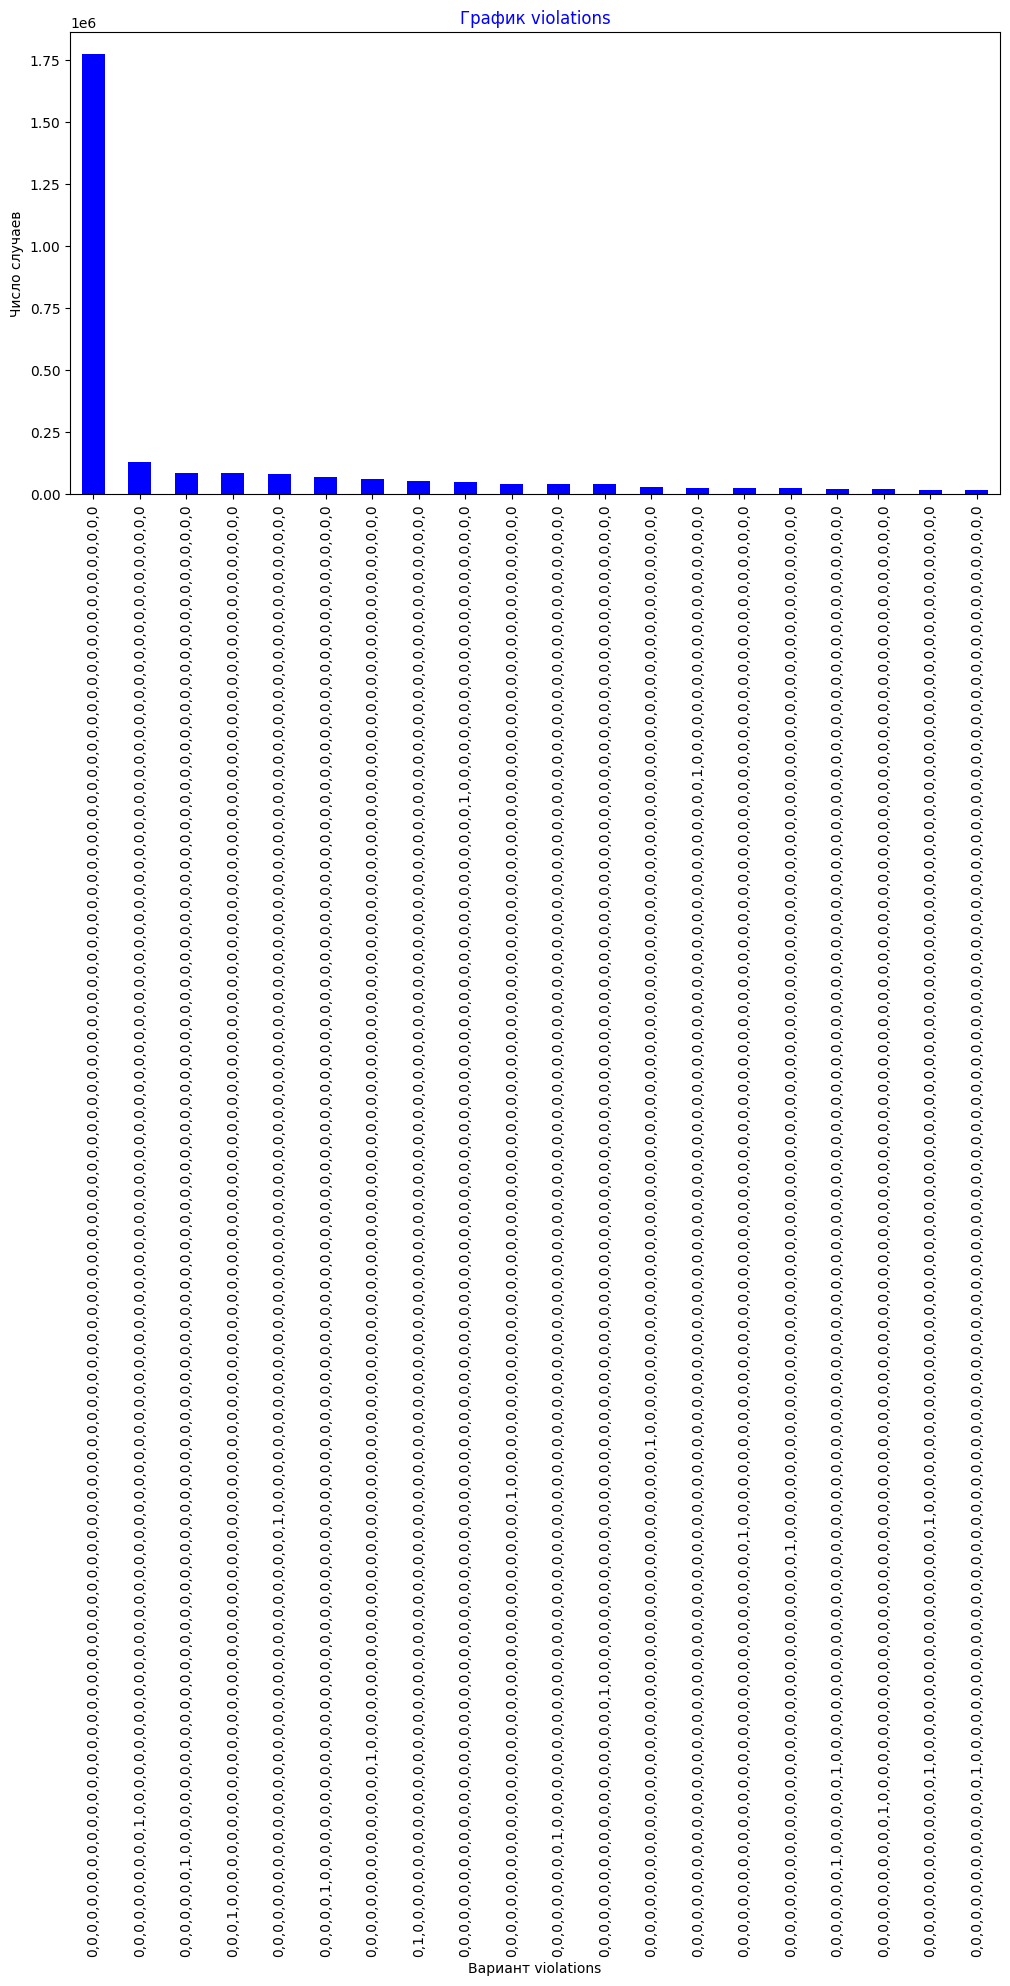

Порядок следования и расположения уникальных элементов (индексов) в строке


,violations
serial_number,
1,NaN
2,Нарушение правил расположения ТС на проезжей части
3,Управление ТС в состоянии алкогольного опьянения
4,Неправильный выбор дистанции
5,Нарушение режима труда и отдыха водителя
...,...
107,Выезд на трамвайные пути встречного направления
108,Нарушение правил учебной езды
109,Пешеход в состоянии наркотического опьянения


In [ ]:
converting_columns_with_lists(data_foot_part, 'violations')


In [ ]:
# Удалим датафрейм из тетрадки
del data_foot_part

In [ ]:
# Как восстановить pickle?
'''
with open("data_vehicles.pickle", 'rb') as file:
    data_vehicles = pickle.load(file)
    '''

'\nwith open("data_vehicles.pickle", \'rb\') as file:\n    data_vehicles = pickle.load(file)\n    '

## 6 Выводы и заключения по Части 1
В этой тетрадке мы произвели:
- Загрузку данных из предоставленных файлов
- Чтение и обработку данных в столбцах в форматах json и в списках
- Формирование новых датафреймов, содержащих:
  - данные о транспортных средствах, участвовавших в ДТП
  - о водителях, пассажирах и пешеходах, участвовавших в ДТП
- Обработку данных, изменение типов данных для уменьшения размера занимаемой оперативной памяти
- Формирование трех сводных датасетов, ообъединяющих в себе данные по всем регионам и соджержащие в себе:
  - данные о ДТП
  - данные о транспортных средствах, участвовавших в ДТП
  - о водителях, пассажирах и пешеходах, участвовавших в ДТП  
- Изучение общей информации о датафрейме
- Выгрузку на диск сводных датасетов в виде файлов формата .pickle

В части 2 (в другой тетрадке) мы проведем:
  - Исследовательский анализ данных
  - Проверку гипотех
  - Построение дашборда
  - Сформируем выводы и заключения